# DQN & PPO Multi-Seed Report

This notebook loads the **best model** from each training run (selected by the combined metric
`mean_reward - std_reward` during training) and runs evaluation and visualization.

No training is required - run `lab011.ipynb` first to generate the model files.

Models are loaded from timestamped run folders: `models/{algo}/{timestamp}/best_model.zip`

---

## 1. Introduction

Deep Reinforcement Learning (DRL) has become a central paradigm for solving complex sequential decision-making problems, particularly those involving continuous state spaces, stochastic dynamics, and delayed rewards. Among the wide range of DRL algorithms, Deep Q-Network (DQN) and Proximal Policy Optimization (PPO) represent two fundamentally different approaches: value-based learning and policy-based learning. Comparing these two algorithms provides valuable insight into how different learning mechanisms behave under the same environment conditions.

In this project, we investigate the performance of DQN and PPO in the LunarLander-v3 environment from Gymnasium. This environment simulates the control of a lunar lander that must descend and touch down smoothly within a designated landing zone. The agent receives an 8-dimensional continuous state vector and must choose among four discrete actions, making the task suitable for both value-based and policy-based methods. The environment includes dense rewards, penalties for fuel consumption, and strong negative rewards for crashes, creating a challenging control problem that requires stability, precision, and efficient exploration.

The goal of this work is to train, evaluate, and compare DQN and PPO under controlled experimental conditions. We analyse their learning curves, sample efficiency, stability across multiple random seeds, and qualitative behaviour through recorded simulations. Additionally, we examine theoretical aspects such as overestimation bias in DQN, the role of clipping and Generalized Advantage Estimation (GAE) in PPO, and the differences between epsilon-greedy and entropy-driven exploration.

By combining quantitative metrics with qualitative observations, this study aims to provide a comprehensive understanding of how DQN and PPO behave in the LunarLander-v3 environment, highlighting their strengths, limitations, and the impact of hyperparameter choices on the final performance.

## 2. Environment Analysis

---

### 2.1 State Space

The LunarLander-v3 environment provides an 8-dimensional continuous state vector describing the physical configuration of the lander at each timestep:
1. Horizontal position (x) relative to the landing zone
2. Vertical position (y) above the ground
3. Horizontal velocity (vx)
4. Vertical velocity (vy)
5. Lander angle ($\theta$)
6. Angular velocity ($\omega$)
7. Left leg contact indicator (0 or 1)
8. Right leg contact indicator (0 or 1)

These variables allow the agent to infer its location, orientation, stability, and motion, which are essential for controlling the descent.

### 2.2 Action Space

The action space is discrete with four possible actions:

* 0 - Do nothing
* 1 - Fire left thruster (pushes the lander to the right)
* 2 - Fire main thruster (reduces vertical speed)
* 3 - Fire right thruster (pushes the lander to the left)

These actions allow the agent to control both horizontal movement and vertical descent.

### 2.3 Reward Function

The reward function is dense and designed to encourage smooth and stable landings while penalizing unsafe or inefficient behaviour.

**Positive rewards include:**
- Moving closer to the landing zone
- Reducing horizontal and vertical velocity
- Maintaining a stable angle
- Each leg touching the ground (+10 each)
- Successful landing (+100 to +140)

**Penalties include:**
- High velocities
- Large tilt angles
- Excessive use of the main thruster (fuel cost)
- Crashes (around -100)

A score of **200 or higher** typically indicates a successful landing.

### 2.4 Termination Rules

An episode terminates when one of the following occurs:
1. **Successful landing** within the designated zone
2. **Crash** due to excessive speed or unstable angle
3. **Leaving the screen boundaries**
4. **Reaching the maximum number of steps** allowed by the environment (1000 timesteps)

These termination conditions apply equally to both PPO and DQN agents.

## 3. Experimental Setup

---

This section describes the training and evaluation methodology used to compare DQN and PPO in the LunarLander-v3 environment. All experiments were conducted under controlled and reproducible conditions to ensure a fair comparison between the two algorithms.

### 3.1 Total Environment Steps

Both DQN and PPO were trained using a total of **1,500,000 environment steps per seed**.
Since the project uses three seeds, this results in:

- 3 seeds x 1,500,000 steps = **4,500,000 training steps per algorithm**

Using the same number of interactions ensures that the comparison between DQN and PPO is based on equal sample budgets.

### 3.2 Hyperparameter Configurations

The hyperparameters for each algorithm were selected based on Stable-Baselines3 recommendations and refined through empirical testing.
Tables 1 and 2 summarize the final configurations used for training.

| Hyperparameter          | Value            |
|-------------------------|------------------|
| Policy                  | MlpPolicy        |
| Learning rate           | linear\_schedule(6.3e-4) |
| Buffer size             | 750,000          |
| Batch size              | 128              |
| Gamma (discount factor) | 0.99             |
| Learning starts         | 50,000           |
| Exploration strategy    | $\epsilon$-greedy |
| Exploration fraction    | 0.12             |
| Final $\epsilon$       | 0.10             |
| Target update interval  | 250              |
| Train frequency         | 4                |
| Gradient steps          | 4                |
| Network architecture    | 2 x 256 MLP      |

**Table 1** - DQN Hyperparameters

| Hyperparameter          | Value            |
|-------------------------|------------------|
| Policy                  | MlpPolicy        |
| Learning rate           | 2.5e-4           |
| n\_steps                | 2048             |
| Batch size              | 64               |
| n\_epochs               | 10               |
| Gamma (discount factor) | 0.999            |
| GAE $\lambda$          | 0.95             |
| Clip range              | 0.20             |
| Entropy coefficient     | 0.01             |
| Network architecture    | 2 x 256 MLP      |

**Table 2** - PPO Hyperparameters

These hyperparameters were kept constant across all seeds to isolate the effect of stochasticity in training.

### 3.3 Random Seeds

To evaluate robustness and training stability, both algorithms were trained using **three different random seeds**:
- Seed 1: **42**
- Seed 2: **123**
- Seed 3: **3407**

Each seed corresponds to a full independent training run of 1,500,000 steps.

### 3.4 Evaluation Protocol

Each trained model was evaluated over **20 deterministic episodes per seed**, for a total of 60 evaluation episodes per algorithm. Deterministic evaluation ensures that the policy is tested without exploration noise, providing a fair assessment of the learned behaviour.

### 3.5 Best-Model Selection

During training, an evaluation callback assessed the model every 25,000 environment steps using 20 deterministic episodes. The best model was selected based on a combined metric: **mean reward - standard deviation**. This metric favours models that are both high-performing and consistent, rather than models that achieve high mean reward with large variance.

### 3.6 Reproducibility

All experiments used fixed random seeds for Python, NumPy, PyTorch, and the Gymnasium environment. Deterministic algorithms were enabled in PyTorch to minimize non-determinism from GPU operations.

In [1]:
import os, sys, glob

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy import stats

import gymnasium as gym
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

import imageio
from IPython.display import Image, display

In [2]:
# Configuration

SEED_LIST = [42, 123, 3407]

ALGORITHM_MAP = {
    "dqn": DQN,
    "ppo": PPO,
}

NOTEBOOK_DIR = os.path.dirname(os.path.abspath("__file__"))
GYMNASIUM_MODEL = "LunarLander-v3"

WIND_ENABLED = False

EVALUATION_EPISODES = 20

TRAJECTORY_EPISODES = 3  # Episodes to visualize per algorithm for trajectory plots

DEVICE = "cpu"

# Session prefix - must match the final model filenames from training
# (e.g. lab011_dqn_42.zip -> SESSION_PREFIX = "lab011")
SESSION_PREFIX = "lab011"

# LunarLander-v3 action labels
ACTION_LABELS = ["Do Nothing", "Fire Left", "Fire Main", "Fire Right"]

# Final hyperparameters used in lab011 training
ALGO_PARAMS = {
    "dqn": {
        "learning_rate": "linear_schedule(6.3e-4)",
        "learning_starts": 50_000,
        "buffer_size": 750_000,
        "batch_size": 128,
        "gamma": 0.99,
        "exploration_fraction": 0.12,
        "exploration_final_eps": 0.1,
        "target_update_interval": 250,
        "train_freq": 4,
        "gradient_steps": 4,
        "policy_kwargs": "net_arch=[256, 256]",
    },
    "ppo": {
        "learning_rate": 2.5e-4,
        "n_steps": 2048,
        "batch_size": 64,
        "n_epochs": 10,
        "gamma": 0.999,
        "gae_lambda": 0.95,
        "ent_coef": 0.01,
        "clip_range": 0.2,
    },
}

TOTAL_TIMESTEPS = 1_500_000

# Plotting constants
algo_colors = {"dqn": "tab:blue", "ppo": "tab:orange"}
algo_names = list(ALGORITHM_MAP.keys())
seed_colors = list(plt.colormaps["tab10"](range(10)))


def discover_best_models(session_prefix):
    """
    Scan models/{algo}/{timestamp}/ folders and return a dict:
        {algo: {seed: path_to_best_model}}
    Only considers runs whose final model filename starts with session_prefix.
    """
    models_root = os.path.join(NOTEBOOK_DIR, "../../../models")
    best_models = {}

    for algo_name in ALGORITHM_MAP:
        best_models[algo_name] = {}
        algo_dir = os.path.join(models_root, algo_name)
        if not os.path.isdir(algo_dir):
            continue

        for run_folder in sorted(glob.glob(os.path.join(algo_dir, "????-??-??_??_??_??"))):
            best_model_path = os.path.join(run_folder, "best_model.zip")
            if not os.path.isfile(best_model_path):
                continue

            for f in os.listdir(run_folder):
                if f.startswith(session_prefix) and f.endswith(".zip") and f != "best_model.zip":
                    seed_str = f.replace(".zip", "").split("_")[-1]
                    if seed_str.isdigit():
                        seed_int = int(seed_str)
                        if seed_int in SEED_LIST:
                            best_models[algo_name][seed_int] = best_model_path
                    break

    return best_models


def discover_final_models(session_prefix):
    """
    Scan models/{algo}/{timestamp}/ folders and return a dict:
        {algo: {seed: path_to_final_model}}
    """
    models_root = os.path.join(NOTEBOOK_DIR, "../../../models")
    final_models = {}

    for algo_name in ALGORITHM_MAP:
        final_models[algo_name] = {}
        algo_dir = os.path.join(models_root, algo_name)
        if not os.path.isdir(algo_dir):
            continue

        for run_folder in sorted(glob.glob(os.path.join(algo_dir, "????-??-??_??_??_??"))):
            for f in os.listdir(run_folder):
                if f.startswith(session_prefix) and f.endswith(".zip") and f != "best_model.zip":
                    seed_str = f.replace(".zip", "").split("_")[-1]
                    if seed_str.isdigit():
                        seed_int = int(seed_str)
                        if seed_int in SEED_LIST:
                            final_models[algo_name][seed_int] = os.path.join(run_folder, f)
                    break

    return final_models


def discover_eval_logs(session_prefix):
    """
    Scan models/{algo}/{timestamp}/eval_log/evaluations.npz and return a dict:
        {algo: {seed: path_to_evaluations_npz}}
    """
    models_root = os.path.join(NOTEBOOK_DIR, "../../../models")
    eval_logs = {}

    for algo_name in ALGORITHM_MAP:
        eval_logs[algo_name] = {}
        algo_dir = os.path.join(models_root, algo_name)
        if not os.path.isdir(algo_dir):
            continue

        for run_folder in sorted(glob.glob(os.path.join(algo_dir, "????-??-??_??_??_??"))):
            eval_log_path = os.path.join(run_folder, "eval_log", "evaluations.npz")
            if not os.path.isfile(eval_log_path):
                continue

            for f in os.listdir(run_folder):
                if f.startswith(session_prefix) and f.endswith(".zip") and f != "best_model.zip":
                    seed_str = f.replace(".zip", "").split("_")[-1]
                    if seed_str.isdigit():
                        seed_int = int(seed_str)
                        if seed_int in SEED_LIST:
                            eval_logs[algo_name][seed_int] = eval_log_path
                    break

    return eval_logs


# Discover models and logs
best_model_paths = discover_best_models(SESSION_PREFIX)
final_model_paths = discover_final_models(SESSION_PREFIX)
eval_log_paths = discover_eval_logs(SESSION_PREFIX)

print(f"Session: {SESSION_PREFIX}")
print(f"Algorithms: {list(ALGORITHM_MAP.keys())}")
print(f"Seeds: {SEED_LIST}")
print(f"Wind enabled: {WIND_ENABLED}")
print(f"Evaluation episodes per seed: {EVALUATION_EPISODES}")
print(f"Device: {DEVICE}")
print()
print("Discovered best models:")
for algo_name in ALGORITHM_MAP:
    for seed in SEED_LIST:
        path = best_model_paths.get(algo_name, {}).get(seed)
        status = path if path else "NOT FOUND"
        print(f"  {algo_name.upper()} seed {seed}: {status}")
print()
print("Discovered eval logs:")
for algo_name in ALGORITHM_MAP:
    for seed in SEED_LIST:
        path = eval_log_paths.get(algo_name, {}).get(seed)
        status = path if path else "NOT FOUND"
        print(f"  {algo_name.upper()} seed {seed}: {status}")

Session: lab011
Algorithms: ['dqn', 'ppo']
Seeds: [42, 123, 3407]
Wind enabled: False
Evaluation episodes per seed: 20
Device: cpu

Discovered best models:
  DQN seed 42: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/../../../models/dqn/2026-02-22_14_20_26/best_model.zip
  DQN seed 123: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/../../../models/dqn/2026-02-22_15_08_59/best_model.zip
  DQN seed 3407: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/../../../models/dqn/2026-02-22_15_56_56/best_model.zip
  PPO seed 42: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/../../../models/ppo/2026-02-22_16_47_57/best_model.zip
  PPO seed 123: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/../../../models/ppo/2026-02-22_17_09_22/best_model.zip
  PPO seed 3407: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/../../../models/ppo/2026-02-22_17_33_36/best_model.zip

Discovered eval logs:
  DQN seed 42: /home/logus/env/iscte/taap_p2/drafts/draft_0

In [3]:
# Load all best models and evaluate

evaluation_results = {}  # {algo: {seed: np.array}}

for algo_name, algo_class in ALGORITHM_MAP.items():
    evaluation_results[algo_name] = {}

    for seed in SEED_LIST:
        load_path = best_model_paths.get(algo_name, {}).get(seed)
        if load_path is None:
            print(f"SKIPPING {algo_name.upper()} seed {seed} - best model not found")
            continue

        print(f"Loading and evaluating {algo_name.upper()} seed {seed} (best model)...")

        def make_env(s=seed):
            env = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)
            env.reset(seed=s)
            return env

        model = algo_class.load(load_path, env=DummyVecEnv([make_env]), device=DEVICE)

        eval_env = Monitor(gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED))
        eval_env.reset(seed=seed)

        rewards, _ = evaluate_policy(
            model,
            eval_env,
            n_eval_episodes=EVALUATION_EPISODES,
            deterministic=True,
            return_episode_rewards=True
        )

        evaluation_results[algo_name][seed] = np.array(rewards)
        eval_env.close()

    print(f"{algo_name.upper()}: evaluation complete.\n")

print(f"All evaluations complete.")

Loading and evaluating DQN seed 42 (best model)...
Loading and evaluating DQN seed 123 (best model)...
Loading and evaluating DQN seed 3407 (best model)...
DQN: evaluation complete.

Loading and evaluating PPO seed 42 (best model)...
Loading and evaluating PPO seed 123 (best model)...
Loading and evaluating PPO seed 3407 (best model)...
PPO: evaluation complete.

All evaluations complete.


---

## Per-Algorithm Results

The following tables summarize the evaluation performance of each algorithm across all seeds. Each model was evaluated over 20 deterministic episodes. The overall row aggregates all episodes across seeds.

In [4]:
# Per-Algorithm: Evaluation Summary Tables

for algo_name in ALGORITHM_MAP:
    rows = []
    for seed in SEED_LIST:
        r = evaluation_results[algo_name][seed]
        rows.append({
            "Seed": seed,
            "Mean Reward": f"{np.mean(r):.2f}",
            "Std Dev": f"{np.std(r):.2f}",
            "Min Reward": f"{np.min(r):.2f}",
            "Max Reward": f"{np.max(r):.2f}",
            "Success Rate": f"{(r >= 200).sum() / len(r) * 100:.1f}%"
        })

    all_r = np.concatenate([evaluation_results[algo_name][s] for s in SEED_LIST])
    rows.append({
        "Seed": "Overall",
        "Mean Reward": f"{np.mean(all_r):.2f}",
        "Std Dev": f"{np.std(all_r):.2f}",
        "Min Reward": f"{np.min(all_r):.2f}",
        "Max Reward": f"{np.max(all_r):.2f}",
        "Success Rate": f"{(all_r >= 200).sum() / len(all_r) * 100:.1f}%"
    })

    print(f"*** {algo_name.upper()} MULTI-SEED EVALUATION SUMMARY ***")
    print(f"Episodes per seed: {EVALUATION_EPISODES} | Total: {len(all_r)}")
    print(pd.DataFrame(rows).to_string(index=False))
    print()

*** DQN MULTI-SEED EVALUATION SUMMARY ***
Episodes per seed: 20 | Total: 60
   Seed Mean Reward Std Dev Min Reward Max Reward Success Rate
     42      278.51   23.70     228.67     318.97       100.0%
    123      283.34   18.19     250.33     319.93       100.0%
   3407      261.22   25.88     215.37     310.74       100.0%
Overall      274.36   24.72     215.37     319.93       100.0%

*** PPO MULTI-SEED EVALUATION SUMMARY ***
Episodes per seed: 20 | Total: 60
   Seed Mean Reward Std Dev Min Reward Max Reward Success Rate
     42      278.43   14.56     251.45     311.70       100.0%
    123      270.83   14.06     242.53     292.55       100.0%
   3407      279.56   19.83     236.91     314.95       100.0%
Overall      276.27   16.81     236.91     314.95       100.0%



These convergence plots show the running mean reward across the 20 evaluation episodes for each seed. The shaded region represents one standard deviation. A flat, high running mean indicates consistent performance.

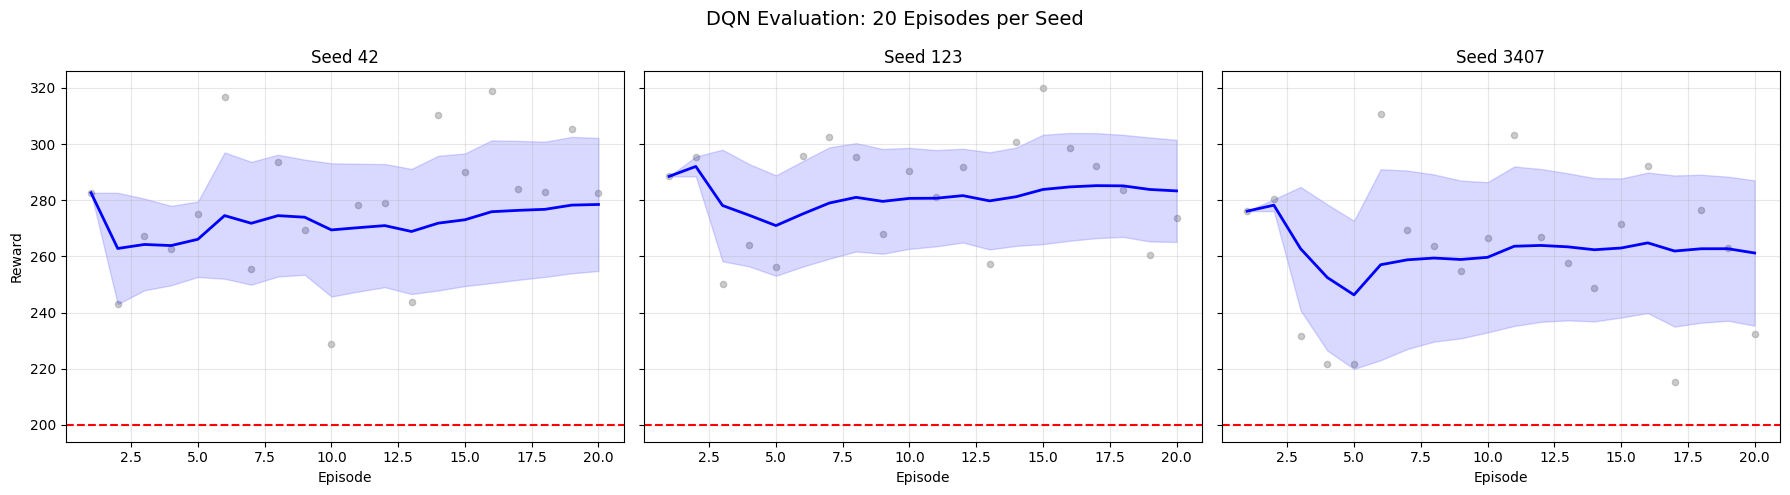

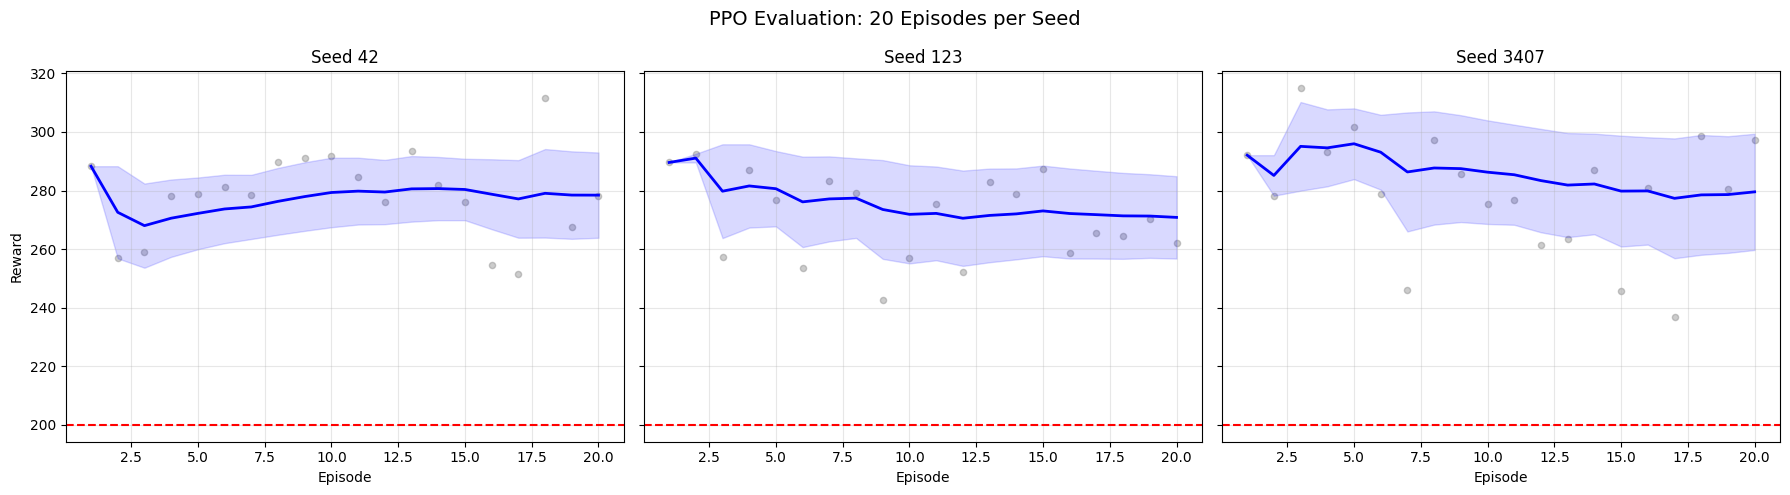

In [5]:
# Per-Algorithm, Per-Seed: Evaluation Convergence Plots

for algo_name in ALGORITHM_MAP:
    fig, axes = plt.subplots(1, len(SEED_LIST), figsize=(6 * len(SEED_LIST), 5), sharey=True)
    if len(SEED_LIST) == 1:
        axes = [axes]

    for ax, seed in zip(axes, SEED_LIST):
        rewards = evaluation_results[algo_name][seed]
        episodes = np.arange(1, len(rewards) + 1)
        running_mean = np.cumsum(rewards) / episodes
        running_std = np.array([np.std(rewards[:i]) for i in episodes])

        ax.scatter(episodes, rewards, color='gray', alpha=0.4, s=20, label='Episode Reward')
        ax.plot(episodes, running_mean, color='blue', linewidth=2, label='Running Mean')
        ax.fill_between(episodes, running_mean - running_std, running_mean + running_std,
                        color='blue', alpha=0.15)
        ax.axhline(y=200, color='red', linestyle='--')
        ax.set_title(f"Seed {seed}")
        ax.set_xlabel("Episode")
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Reward")
    fig.suptitle(f"{algo_name.upper()} Evaluation: {EVALUATION_EPISODES} Episodes per Seed", fontsize=14)
    plt.tight_layout()
    plt.show()

**Figure 1** - Per-seed evaluation convergence showing running mean reward and standard deviation across 20 deterministic episodes.

Mean reward per seed with standard deviation error bars. The horizontal blue line marks the overall mean across all seeds, while the red dashed line marks the solved threshold of 200.

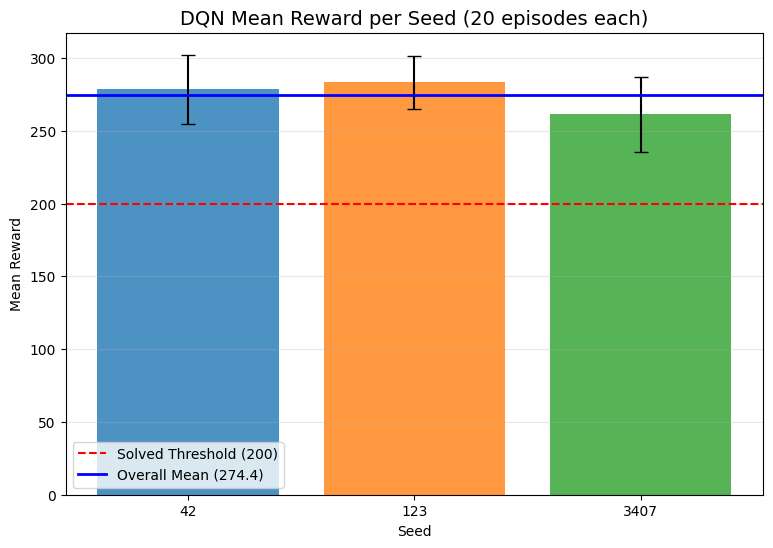

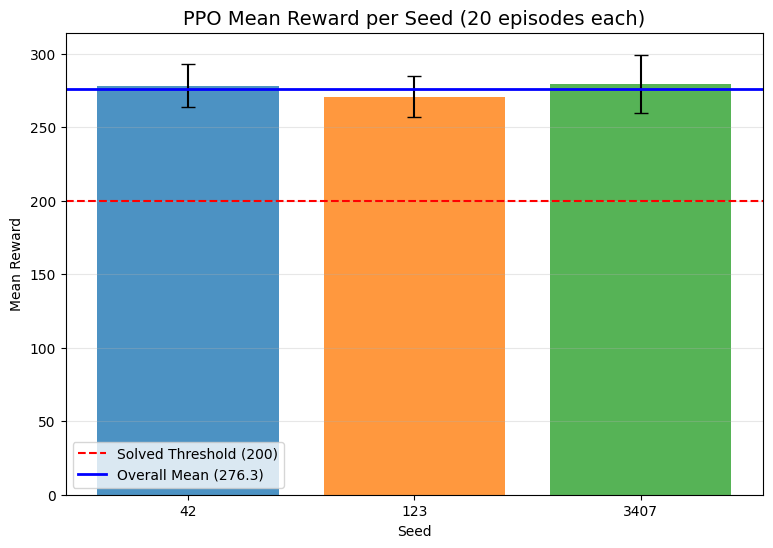

In [6]:
# Per-Algorithm: Evaluation Bar Chart (mean reward per seed with error bars)

for algo_name in ALGORITHM_MAP:
    all_r = np.concatenate([evaluation_results[algo_name][s] for s in SEED_LIST])
    means = [np.mean(evaluation_results[algo_name][s]) for s in SEED_LIST]
    stds = [np.std(evaluation_results[algo_name][s]) for s in SEED_LIST]
    labels = [str(s) for s in SEED_LIST]

    plt.figure(figsize=(max(8, 3 * len(SEED_LIST)), 6))
    plt.bar(labels, means, yerr=stds, capsize=5, color=seed_colors[:len(SEED_LIST)], alpha=0.8)
    plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')
    plt.axhline(y=float(np.mean(all_r)), color='blue', linestyle='-', linewidth=2,
                label=f'Overall Mean ({np.mean(all_r):.1f})')

    plt.title(f"{algo_name.upper()} Mean Reward per Seed ({EVALUATION_EPISODES} episodes each)", fontsize=14)
    plt.xlabel("Seed")
    plt.ylabel("Mean Reward")
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.show()

**Figure 2** - Mean evaluation reward per seed with standard deviation error bars, compared against the overall mean and solved threshold.

Reward distribution histograms overlaid per seed. The spread and overlap of these distributions indicate how consistent each seed's policy is. A tight cluster above 200 suggests a robust, well-trained agent.

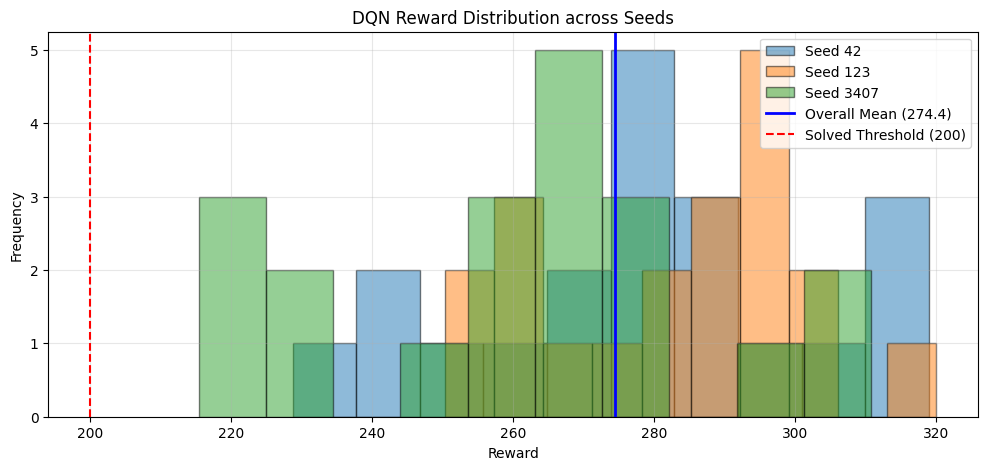

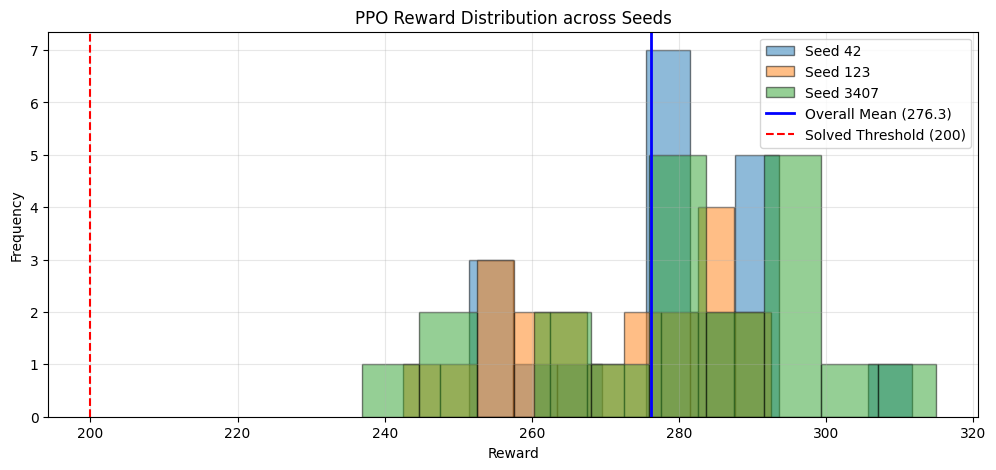

In [7]:
# Per-Algorithm: Reward Distribution Histograms (overlaid per seed)

for algo_name in ALGORITHM_MAP:
    all_r = np.concatenate([evaluation_results[algo_name][s] for s in SEED_LIST])

    plt.figure(figsize=(12, 5))
    for i, seed in enumerate(SEED_LIST):
        plt.hist(evaluation_results[algo_name][seed], bins=10, alpha=0.5,
                 color=seed_colors[i], edgecolor='black', label=f"Seed {seed}")

    plt.axvline(x=float(np.mean(all_r)), color='blue', linestyle='-', linewidth=2,
                label=f'Overall Mean ({np.mean(all_r):.1f})')
    plt.axvline(x=200, color='red', linestyle='--', label='Solved Threshold (200)')
    plt.title(f'{algo_name.upper()} Reward Distribution across Seeds')
    plt.xlabel('Reward')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

**Figure 3** - Per-seed reward distribution for each algorithm, showing the spread and concentration of evaluation episode rewards.

---

## Cross-Algorithm Comparison

Aggregated comparison of both algorithms across all seeds. This table provides the headline numbers for the DQN vs PPO comparison.

In [8]:
# Cross-Algorithm: Combined Summary Table

rows = []
for algo_name in ALGORITHM_MAP:
    all_r = np.concatenate([evaluation_results[algo_name][s] for s in SEED_LIST])
    rows.append({
        "Algorithm": algo_name.upper(),
        "Mean Reward": f"{np.mean(all_r):.2f}",
        "Std Dev": f"{np.std(all_r):.2f}",
        "Min Reward": f"{np.min(all_r):.2f}",
        "Max Reward": f"{np.max(all_r):.2f}",
        "Success Rate": f"{(all_r >= 200).sum() / len(all_r) * 100:.1f}%"
    })

print(f"*** CROSS-ALGORITHM EVALUATION SUMMARY ***")
print(f"Seeds: {SEED_LIST} | Episodes per seed: {EVALUATION_EPISODES}")
print(f"Total episodes per algorithm: {EVALUATION_EPISODES * len(SEED_LIST)}")
print()
print(pd.DataFrame(rows).to_string(index=False))

*** CROSS-ALGORITHM EVALUATION SUMMARY ***
Seeds: [42, 123, 3407] | Episodes per seed: 20
Total episodes per algorithm: 60

Algorithm Mean Reward Std Dev Min Reward Max Reward Success Rate
      DQN      274.36   24.72     215.37     319.93       100.0%
      PPO      276.27   16.81     236.91     314.95       100.0%


Side-by-side mean reward per seed, allowing direct comparison of how each algorithm performed under identical random conditions.

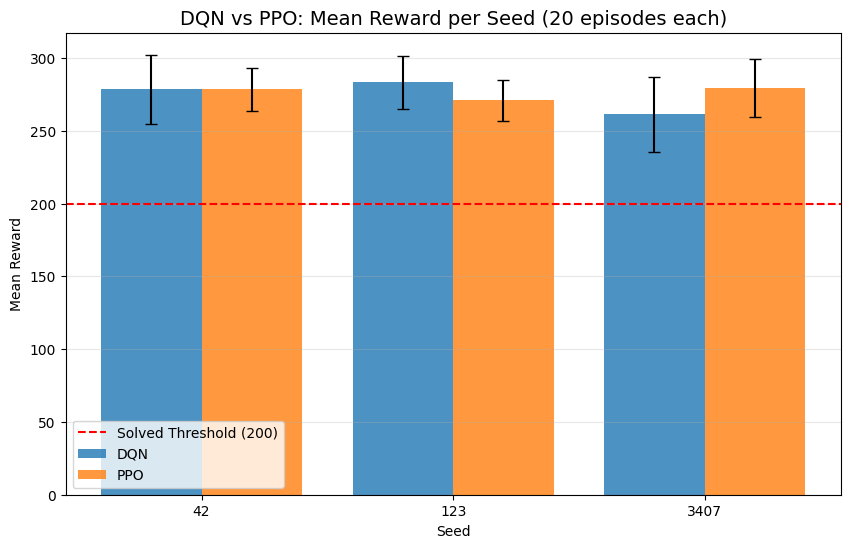

In [9]:
# Cross-Algorithm: Grouped Bar Chart (DQN vs PPO per seed)

n_algos = len(algo_names)
n_seeds = len(SEED_LIST)
bar_width = 0.8 / n_algos
x = np.arange(n_seeds)

plt.figure(figsize=(max(10, 3 * n_seeds), 6))
for i, algo_name in enumerate(algo_names):
    means = [np.mean(evaluation_results[algo_name][s]) for s in SEED_LIST]
    stds = [np.std(evaluation_results[algo_name][s]) for s in SEED_LIST]
    offset = (i - (n_algos - 1) / 2) * bar_width
    plt.bar(x + offset, means, bar_width, yerr=stds, capsize=4,
            label=algo_name.upper(), alpha=0.8)

plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')
plt.xticks(x, [str(s) for s in SEED_LIST])
plt.title(f"DQN vs PPO: Mean Reward per Seed ({EVALUATION_EPISODES} episodes each)", fontsize=14)
plt.xlabel("Seed")
plt.ylabel("Mean Reward")
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

**Figure 4** - Side-by-side comparison of DQN and PPO mean reward per seed, evaluated over 20 deterministic episodes each.

Overall mean reward collapsed across all seeds and episodes. This is the single summary number for each algorithm's evaluation performance.

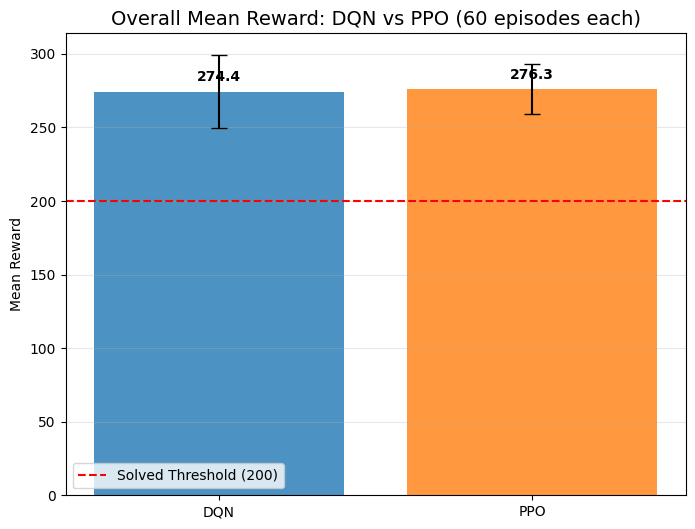

In [10]:
# Cross-Algorithm: Overall Mean Reward Bar Chart

overall_means = []
overall_stds = []
for algo_name in algo_names:
    all_r = np.concatenate([evaluation_results[algo_name][s] for s in SEED_LIST])
    overall_means.append(np.mean(all_r))
    overall_stds.append(np.std(all_r))

plt.figure(figsize=(8, 6))
bars = plt.bar([a.upper() for a in algo_names], overall_means, yerr=overall_stds,
               capsize=6, color=[algo_colors[a] for a in algo_names], alpha=0.8)
plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')

for bar, mean in zip(bars, overall_means):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             f'{mean:.1f}', ha='center', va='bottom', fontweight='bold')

plt.title(f"Overall Mean Reward: DQN vs PPO ({EVALUATION_EPISODES * len(SEED_LIST)} episodes each)", fontsize=14)
plt.ylabel("Mean Reward")
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

**Figure 5** - Overall mean evaluation reward for each algorithm, aggregated across all seeds and episodes.

Overlaid reward distributions for DQN and PPO. The degree of overlap and relative position of the two distributions illustrates the practical difference between the algorithms.

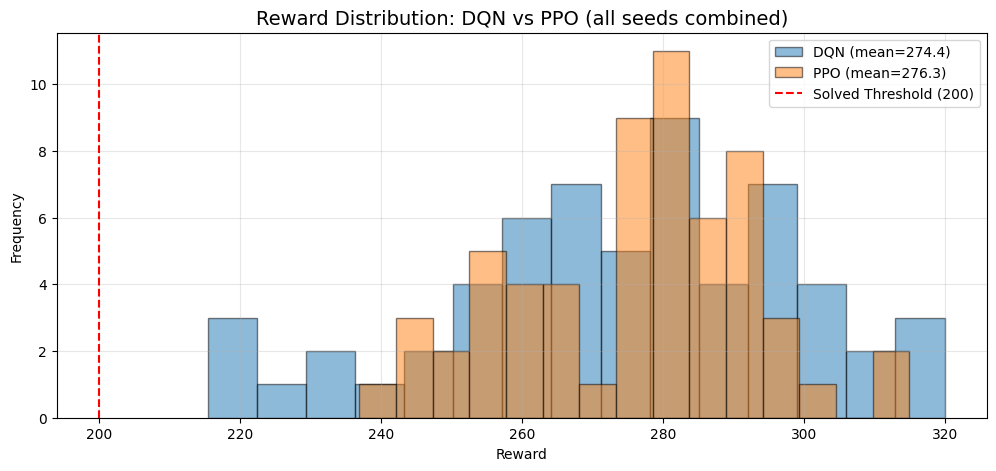

In [11]:
# Cross-Algorithm: Reward Distribution Comparison (overlaid histograms)

plt.figure(figsize=(12, 5))
for algo_name in algo_names:
    all_r = np.concatenate([evaluation_results[algo_name][s] for s in SEED_LIST])
    plt.hist(all_r, bins=15, alpha=0.5, color=algo_colors[algo_name],
             edgecolor='black', label=f"{algo_name.upper()} (mean={np.mean(all_r):.1f})")

plt.axvline(x=200, color='red', linestyle='--', label='Solved Threshold (200)')
plt.title('Reward Distribution: DQN vs PPO (all seeds combined)', fontsize=14)
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Figure 6** - Overlaid reward distributions for DQN and PPO across all seeds, illustrating the practical performance gap between algorithms.

Box plots showing the median, quartiles, and outliers of evaluation rewards for each algorithm, broken down by seed. Differences in box width and whisker length indicate variability.

/tmp/ipykernel_222710/3208474440.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=[a.upper() for a in algo_names], patch_artist=True)
/tmp/ipykernel_222710/3208474440.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=[a.upper() for a in algo_names], patch_artist=True)
/tmp/ipykernel_222710/3208474440.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=[a.upper() for a in algo_names], patch_artist=True)


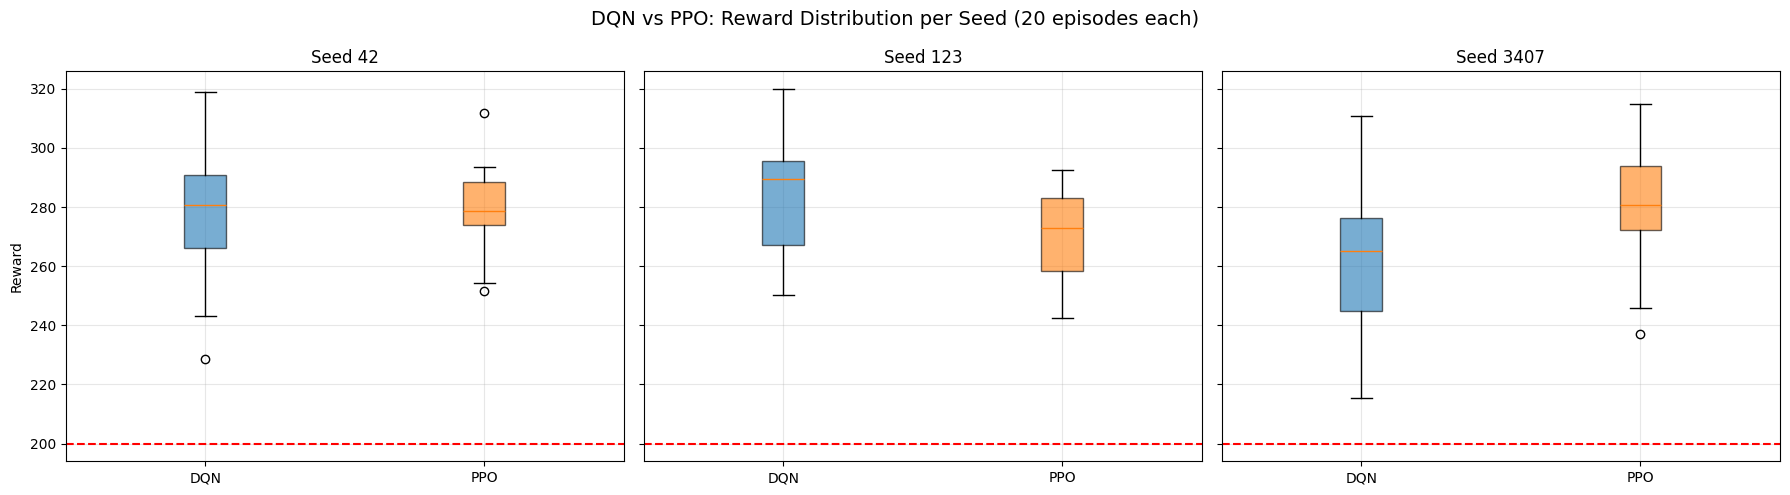

In [12]:
# Cross-Algorithm: Box Plot Comparison per Seed

fig, axes = plt.subplots(1, len(SEED_LIST), figsize=(6 * len(SEED_LIST), 5), sharey=True)
if len(SEED_LIST) == 1:
    axes = [axes]

for ax, seed in zip(axes, SEED_LIST):
    data = [evaluation_results[algo_name][seed] for algo_name in algo_names]
    bp = ax.boxplot(data, labels=[a.upper() for a in algo_names], patch_artist=True)
    for patch, algo_name in zip(bp['boxes'], algo_names):
        patch.set_facecolor(algo_colors[algo_name])
        patch.set_alpha(0.6)
    ax.axhline(y=200, color='red', linestyle='--')
    ax.set_title(f"Seed {seed}")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Reward")
fig.suptitle(f"DQN vs PPO: Reward Distribution per Seed ({EVALUATION_EPISODES} episodes each)", fontsize=14)
plt.tight_layout()
plt.show()

**Figure 7** - Box plot comparison of evaluation reward distributions per seed, showing median, interquartile range, and outliers for each algorithm.

---

## Statistical Significance

Two statistical tests assess whether the observed performance difference between DQN and PPO is significant. The Mann-Whitney U test compares reward distributions (non-parametric, no normality assumption). The Chi-squared test compares success rates as a proportion.

In [13]:
# Statistical Significance: Mann-Whitney U Tests

algo_all_rewards = {}
for algo_name in algo_names:
    algo_all_rewards[algo_name] = np.concatenate([evaluation_results[algo_name][s] for s in SEED_LIST])

# Reward comparison (Mann-Whitney U)
mwu_result = stats.mannwhitneyu(
    algo_all_rewards[algo_names[0]],
    algo_all_rewards[algo_names[1]],
    alternative='two-sided'
)
stat_reward = float(mwu_result.statistic)
p_reward = float(mwu_result.pvalue)

# Success rate comparison (Chi-squared)
successes = []
totals = []
for algo_name in algo_names:
    r = algo_all_rewards[algo_name]
    successes.append(int((r >= 200).sum()))
    totals.append(len(r))

failures = [t - s for t, s in zip(totals, successes)]
contingency = np.array([successes, failures])

if np.all(contingency.sum(axis=1) > 0) and np.all(contingency.sum(axis=0) > 0):
    chi2_result = stats.chi2_contingency(contingency)
    chi2 = float(chi2_result[0])
    p_success = float(chi2_result[1])
    chi2_valid = True
else:
    chi2, p_success = 0.0, 1.0
    chi2_valid = False

chi2_note = "" if chi2_valid else " (skipped: zero row/col)"
rows = [
    {
        "Metric": "Mean Reward",
        f"{algo_names[0].upper()} Value": f"{np.mean(algo_all_rewards[algo_names[0]]):.2f}",
        f"{algo_names[1].upper()} Value": f"{np.mean(algo_all_rewards[algo_names[1]]):.2f}",
        "Test": "Mann-Whitney U",
        "Statistic": f"{stat_reward:.1f}",
        "p-value": f"{p_reward:.4f}",
        "Significant (p<0.05)": "Yes" if p_reward < 0.05 else "No"
    },
    {
        "Metric": "Success Rate (>=200)",
        f"{algo_names[0].upper()} Value": f"{successes[0]/totals[0]*100:.1f}%",
        f"{algo_names[1].upper()} Value": f"{successes[1]/totals[1]*100:.1f}%",
        "Test": f"Chi-squared{chi2_note}",
        "Statistic": f"{chi2:.2f}",
        "p-value": f"{p_success:.4f}",
        "Significant (p<0.05)": "Yes" if (chi2_valid and p_success < 0.05) else "No"
    },
]

print("*** STATISTICAL SIGNIFICANCE TESTS ***")
print(f"Sample size per algorithm: {totals[0]} episodes ({EVALUATION_EPISODES} episodes x {len(SEED_LIST)} seeds)")
print()
print(pd.DataFrame(rows).to_string(index=False))

*** STATISTICAL SIGNIFICANCE TESTS ***
Sample size per algorithm: 60 episodes (20 episodes x 3 seeds)

              Metric DQN Value PPO Value                                Test Statistic p-value Significant (p<0.05)
         Mean Reward    274.36    276.27                      Mann-Whitney U    1771.0  0.8811                   No
Success Rate (>=200)    100.0%    100.0% Chi-squared (skipped: zero row/col)      0.00  1.0000                   No


---

## Baseline Comparison

In [14]:
# Random Agent Baseline Evaluation

random_results = {}

for seed in SEED_LIST:
    print(f"Running random agent with seed {seed}...")
    env = gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED)
    env.action_space.seed(seed)
    episode_rewards = []

    for ep in range(EVALUATION_EPISODES):
        obs, info = env.reset(seed=seed + ep)
        total_reward = 0.0
        done = False

        while not done:
            action = env.action_space.sample()
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += float(reward)
            done = terminated or truncated

        episode_rewards.append(total_reward)

    random_results[seed] = np.array(episode_rewards)
    env.close()

print("Random baseline evaluation complete.")

Running random agent with seed 42...
Running random agent with seed 123...
Running random agent with seed 3407...
Random baseline evaluation complete.


A random agent serves as a lower-bound baseline. This table and chart show how far DQN and PPO have improved over pure random action selection.

*** BASELINE COMPARISON ***
 Agent Mean Reward Std Dev     Min    Max Success Rate
Random     -207.06  110.45 -416.10  15.45         0.0%
   DQN      274.36   24.72  215.37 319.93       100.0%
   PPO      276.27   16.81  236.91 314.95       100.0%



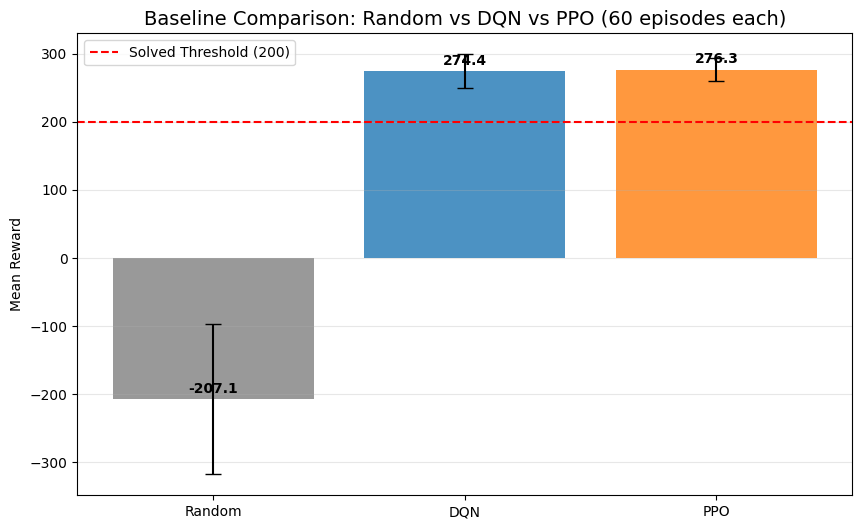

In [15]:
# Baseline Comparison: Table + Chart

algo_all_rewards = {a: np.concatenate([evaluation_results[a][s] for s in SEED_LIST]) for a in algo_names}
all_random = np.concatenate([random_results[s] for s in SEED_LIST])

rows = [
    {
        "Agent": "Random",
        "Mean Reward": f"{np.mean(all_random):.2f}",
        "Std Dev": f"{np.std(all_random):.2f}",
        "Min": f"{np.min(all_random):.2f}",
        "Max": f"{np.max(all_random):.2f}",
        "Success Rate": f"{(all_random >= 200).sum() / len(all_random) * 100:.1f}%"
    }
]
for algo_name in algo_names:
    all_r = algo_all_rewards[algo_name]
    rows.append({
        "Agent": algo_name.upper(),
        "Mean Reward": f"{np.mean(all_r):.2f}",
        "Std Dev": f"{np.std(all_r):.2f}",
        "Min": f"{np.min(all_r):.2f}",
        "Max": f"{np.max(all_r):.2f}",
        "Success Rate": f"{(all_r >= 200).sum() / len(all_r) * 100:.1f}%"
    })

print("*** BASELINE COMPARISON ***")
print(pd.DataFrame(rows).to_string(index=False))
print()

# Bar chart
agent_labels = ["Random"] + [a.upper() for a in algo_names]
agent_means = [np.mean(all_random)] + [np.mean(algo_all_rewards[a]) for a in algo_names]
agent_stds = [np.std(all_random)] + [np.std(algo_all_rewards[a]) for a in algo_names]
bar_colors = ["gray"] + [algo_colors[a] for a in algo_names]

plt.figure(figsize=(10, 6))
bars = plt.bar(agent_labels, agent_means, yerr=agent_stds, capsize=6,
               color=bar_colors, alpha=0.8)
plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')

for bar, mean in zip(bars, agent_means):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             f'{mean:.1f}', ha='center', va='bottom', fontweight='bold')

plt.title(f"Baseline Comparison: Random vs DQN vs PPO ({EVALUATION_EPISODES * len(SEED_LIST)} episodes each)", fontsize=14)
plt.ylabel("Mean Reward")
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

**Figure 8** - Mean reward comparison between a random agent baseline and trained DQN and PPO agents.

---

## Agent Behavior Analysis

In [16]:
# Collect per-step data: actions and trajectories

action_counts = {}       # {algo: np.array of shape (4,)} total action counts
trajectory_data = {}     # {algo: list of (x_positions, y_positions)} one per TRAJECTORY_EPISODES

for algo_name, algo_class in ALGORITHM_MAP.items():
    action_counts[algo_name] = np.zeros(len(ACTION_LABELS), dtype=int)
    trajectory_data[algo_name] = []

    for seed in SEED_LIST:
        load_path = best_model_paths.get(algo_name, {}).get(seed)
        if load_path is None:
            continue

        def make_env(s=seed):
            env = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)
            env.reset(seed=s)
            return env

        model = algo_class.load(load_path, env=DummyVecEnv([make_env]), device=DEVICE)
        env = gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED)

        for ep in range(EVALUATION_EPISODES):
            obs, info = env.reset(seed=seed + ep)
            done = False
            x_pos, y_pos = [obs[0]], [obs[1]]

            while not done:
                action, _ = model.predict(obs, deterministic=True)
                action_int = int(action)
                action_counts[algo_name][action_int] += 1

                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                x_pos.append(obs[0])
                y_pos.append(obs[1])

            if seed == SEED_LIST[0] and ep < TRAJECTORY_EPISODES:
                trajectory_data[algo_name].append((np.array(x_pos), np.array(y_pos)))

        env.close()

    total_actions = action_counts[algo_name].sum()
    print(f"{algo_name.upper()}: {total_actions:,} total actions collected across {EVALUATION_EPISODES * len(SEED_LIST)} episodes")

print("\nBehavior data collection complete.")

DQN: 14,451 total actions collected across 60 episodes
PPO: 16,544 total actions collected across 60 episodes

Behavior data collection complete.


Action distribution comparison reveals the control strategies learned by each algorithm. Differences in the relative frequency of main engine vs side engine usage reflect different learned landing policies.

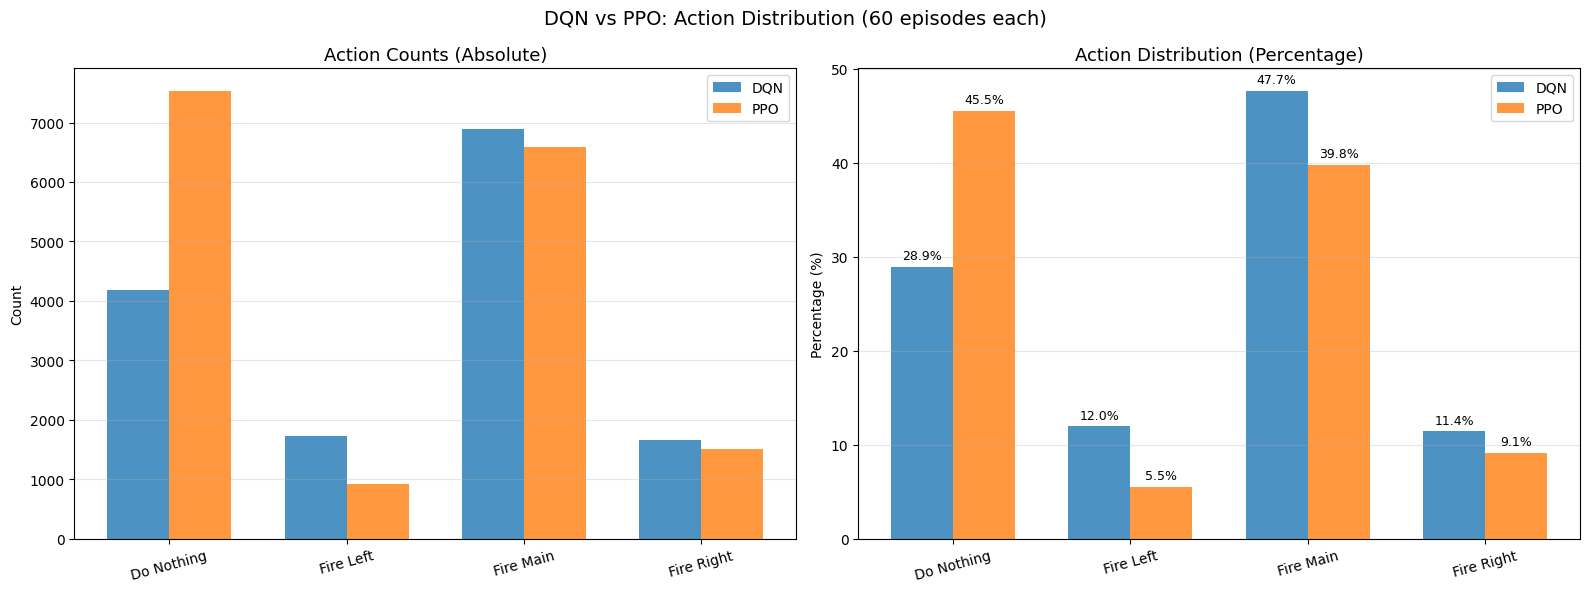

In [17]:
# Action Distribution: DQN vs PPO

n_actions = len(ACTION_LABELS)
x = np.arange(n_actions)
bar_width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Absolute counts
for i, algo_name in enumerate(algo_names):
    offset = (i - 0.5) * bar_width
    ax1.bar(x + offset, action_counts[algo_name], bar_width,
            label=algo_name.upper(), color=algo_colors[algo_name], alpha=0.8)

ax1.set_xticks(x)
ax1.set_xticklabels(ACTION_LABELS, rotation=15)
ax1.set_title("Action Counts (Absolute)", fontsize=13)
ax1.set_ylabel("Count")
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Percentage distribution
for i, algo_name in enumerate(algo_names):
    pcts = action_counts[algo_name] / action_counts[algo_name].sum() * 100
    offset = (i - 0.5) * bar_width
    bars = ax2.bar(x + offset, pcts, bar_width,
                   label=algo_name.upper(), color=algo_colors[algo_name], alpha=0.8)
    for bar, pct in zip(bars, pcts):
        ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
                 f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

ax2.set_xticks(x)
ax2.set_xticklabels(ACTION_LABELS, rotation=15)
ax2.set_title("Action Distribution (Percentage)", fontsize=13)
ax2.set_ylabel("Percentage (%)")
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

fig.suptitle(f"DQN vs PPO: Action Distribution ({EVALUATION_EPISODES * len(SEED_LIST)} episodes each)", fontsize=14)
plt.tight_layout()
plt.show()

**Figure 9** - Action usage frequency (absolute counts and percentage) for DQN and PPO across all evaluation episodes.

2D trajectory plots (x vs y position) for sample episodes from each algorithm. The circle marker indicates the spawn point and the cross marker indicates the final position. The red triangle marks the landing pad.

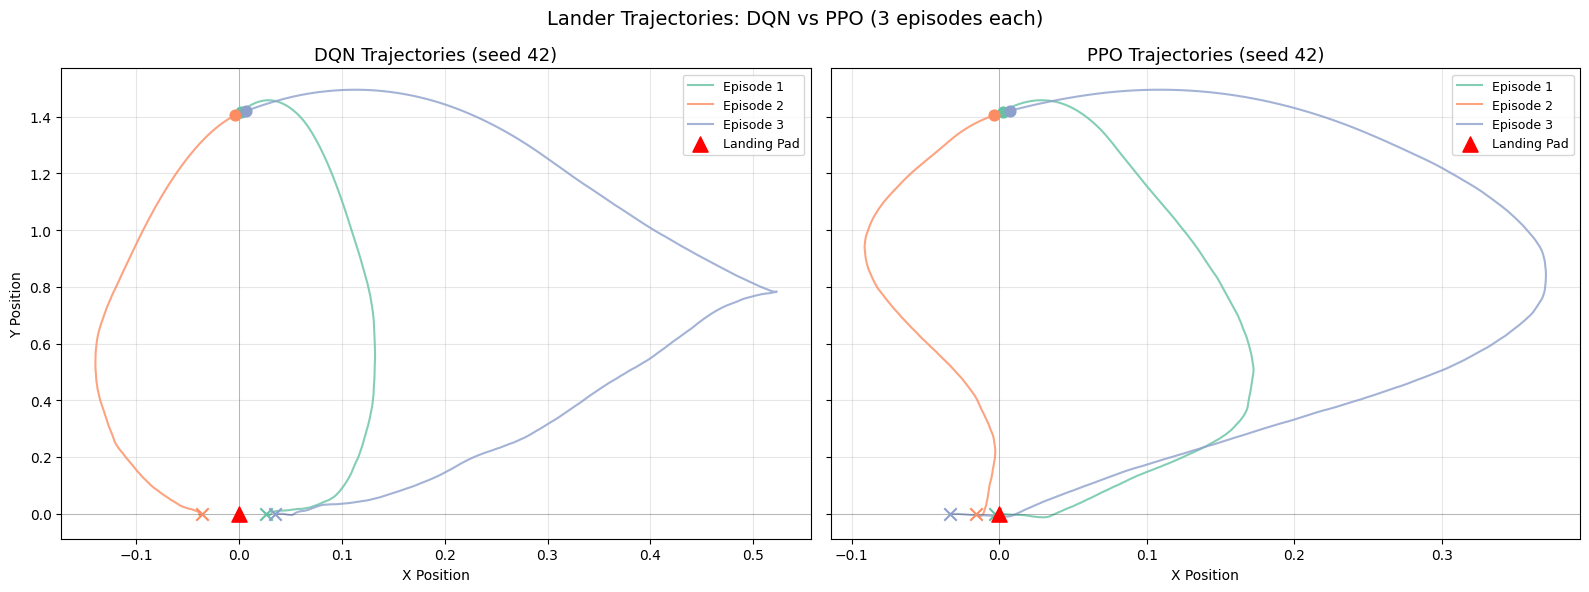

In [18]:
# Trajectory Plots: x-y paths of the lander

fig, axes = plt.subplots(1, len(algo_names), figsize=(8 * len(algo_names), 6), sharey=True)
if len(algo_names) == 1:
    axes = [axes]

traj_colors = list(plt.colormaps["Set2"](range(8)))

for ax, algo_name in zip(axes, algo_names):
    for i, (x_pos, y_pos) in enumerate(trajectory_data[algo_name]):
        ax.plot(x_pos, y_pos, color=traj_colors[i], linewidth=1.5, alpha=0.8,
                label=f"Episode {i+1}")
        ax.scatter(x_pos[0], y_pos[0], color=traj_colors[i], marker='o', s=60, zorder=5)
        ax.scatter(x_pos[-1], y_pos[-1], color=traj_colors[i], marker='x', s=80, zorder=5)

    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.scatter(0, 0, color='red', marker='^', s=120, zorder=10, label='Landing Pad')

    ax.set_title(f"{algo_name.upper()} Trajectories (seed {SEED_LIST[0]})", fontsize=13)
    ax.set_xlabel("X Position")
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Y Position")
fig.suptitle(f"Lander Trajectories: DQN vs PPO ({TRAJECTORY_EPISODES} episodes each)", fontsize=14)
plt.tight_layout()
plt.show()

**Figure 10** - Sample landing trajectories (x-y position) for each algorithm, showing descent path from spawn to final position.

Direct overlay of one trajectory from each algorithm on the same chart, highlighting differences in descent path, horizontal correction strategy, and final approach angle.

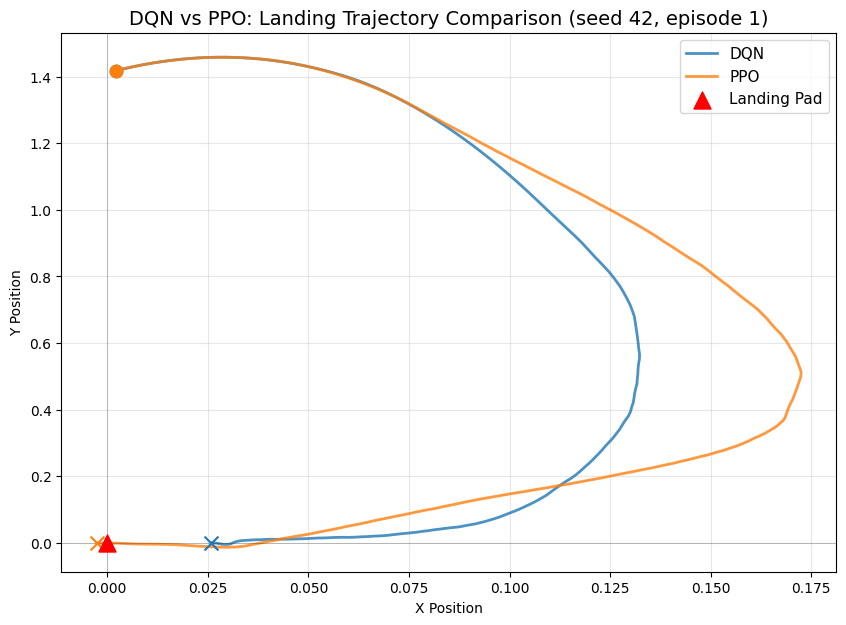

In [19]:
# Trajectory Comparison: DQN vs PPO overlaid on one chart

plt.figure(figsize=(10, 7))

for algo_name in algo_names:
    x_pos, y_pos = trajectory_data[algo_name][0]
    plt.plot(x_pos, y_pos, color=algo_colors[algo_name], linewidth=2, alpha=0.8,
             label=f"{algo_name.upper()}")
    plt.scatter(x_pos[0], y_pos[0], color=algo_colors[algo_name], marker='o', s=80, zorder=5)
    plt.scatter(x_pos[-1], y_pos[-1], color=algo_colors[algo_name], marker='x', s=100, zorder=5)

plt.scatter(0, 0, color='red', marker='^', s=150, zorder=10, label='Landing Pad')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)

plt.title(f"DQN vs PPO: Landing Trajectory Comparison (seed {SEED_LIST[0]}, episode 1)", fontsize=14)
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

**Figure 11** - Direct overlay of DQN and PPO landing trajectories for the same seed and episode, highlighting differences in approach strategy.

---

## Sample Efficiency Analysis

These charts show how each algorithm's mean reward and success rate evolved during training, plotted against environment steps (not episodes). This is the key sample efficiency comparison: a curve that rises earlier indicates faster learning. The shaded region represents one standard deviation across seeds.

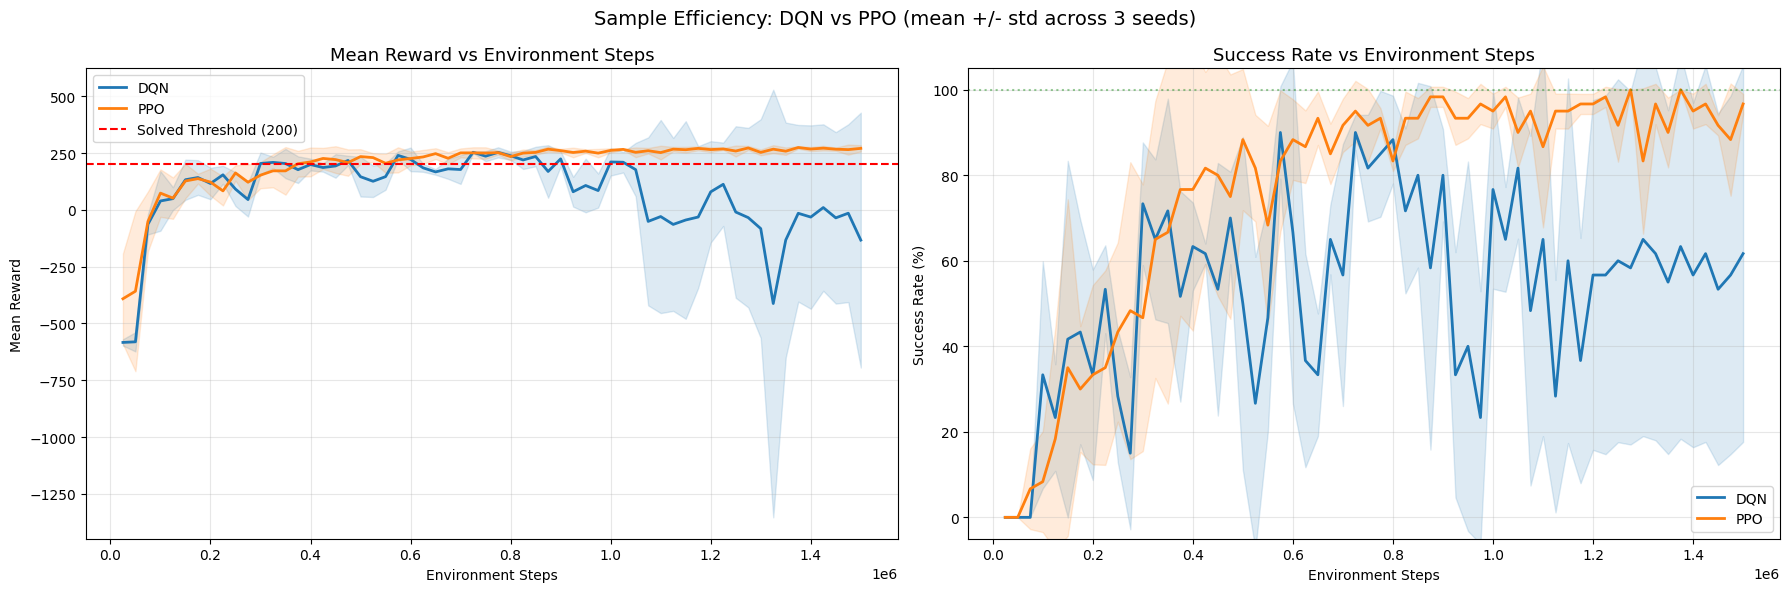

In [20]:
# Sample Efficiency: Mean Reward and Success Rate vs Training Timesteps
# Extracted from the EvalCallback logs (evaluations.npz)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

for algo_name in algo_names:
    all_timesteps = None
    all_mean_rewards = []
    all_success_rates = []

    for seed in SEED_LIST:
        log_path = eval_log_paths.get(algo_name, {}).get(seed)
        if log_path is None:
            continue

        data = np.load(log_path, allow_pickle=True)
        timesteps = data["timesteps"]
        results = data["results"]

        mean_rewards = np.array([np.mean(r) for r in results])
        success_rates = np.array([np.sum(r >= 200) / len(r) * 100 for r in results])

        if all_timesteps is None:
            all_timesteps = timesteps
        all_mean_rewards.append(mean_rewards[:len(all_timesteps)])
        all_success_rates.append(success_rates[:len(all_timesteps)])

    if all_timesteps is None or not all_mean_rewards:
        continue

    # Align to shortest
    min_len = min(len(a) for a in all_mean_rewards)
    all_timesteps = all_timesteps[:min_len]
    all_mean_rewards = np.array([a[:min_len] for a in all_mean_rewards])
    all_success_rates = np.array([a[:min_len] for a in all_success_rates])

    mean_r = all_mean_rewards.mean(axis=0)
    std_r = all_mean_rewards.std(axis=0)
    mean_s = all_success_rates.mean(axis=0)
    std_s = all_success_rates.std(axis=0)

    ax1.plot(all_timesteps, mean_r, color=algo_colors[algo_name], linewidth=2, label=algo_name.upper())
    ax1.fill_between(all_timesteps, mean_r - std_r, mean_r + std_r, color=algo_colors[algo_name], alpha=0.15)

    ax2.plot(all_timesteps, mean_s, color=algo_colors[algo_name], linewidth=2, label=algo_name.upper())
    ax2.fill_between(all_timesteps, mean_s - std_s, mean_s + std_s, color=algo_colors[algo_name], alpha=0.15)

ax1.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')
ax1.set_title("Mean Reward vs Environment Steps", fontsize=13)
ax1.set_xlabel("Environment Steps")
ax1.set_ylabel("Mean Reward")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.axhline(y=100, color='green', linestyle=':', alpha=0.4)
ax2.set_title("Success Rate vs Environment Steps", fontsize=13)
ax2.set_xlabel("Environment Steps")
ax2.set_ylabel("Success Rate (%)")
ax2.set_ylim(-5, 105)
ax2.legend()
ax2.grid(True, alpha=0.3)

fig.suptitle(f"Sample Efficiency: DQN vs PPO (mean +/- std across {len(SEED_LIST)} seeds)", fontsize=14)
plt.tight_layout()
plt.show()

**Figure 12** - Mean evaluation reward and success rate plotted against training environment steps, comparing the learning speed of DQN and PPO.

This table reports the exact training timestep at which each algorithm first achieved a mean evaluation reward above the solved threshold. Lower values indicate better sample efficiency.

In [21]:
# Sample Efficiency: Timestep at which each algorithm first crossed the solved threshold
# per seed and on average

solved_threshold = 200

rows = []
for algo_name in algo_names:
    first_solved_steps = []

    for seed in SEED_LIST:
        log_path = eval_log_paths.get(algo_name, {}).get(seed)
        if log_path is None:
            first_solved_steps.append(None)
            continue

        data = np.load(log_path, allow_pickle=True)
        timesteps = data["timesteps"]
        results = data["results"]

        found = False
        for i, r in enumerate(results):
            if np.mean(r) >= solved_threshold:
                first_solved_steps.append(int(timesteps[i]))
                rows.append({
                    "Algorithm": algo_name.upper(),
                    "Seed": seed,
                    "First Solved at Step": f"{int(timesteps[i]):,}",
                })
                found = True
                break

        if not found:
            first_solved_steps.append(None)
            rows.append({
                "Algorithm": algo_name.upper(),
                "Seed": seed,
                "First Solved at Step": "Not reached",
            })

    valid = [s for s in first_solved_steps if s is not None]
    if valid:
        rows.append({
            "Algorithm": algo_name.upper(),
            "Seed": "Mean",
            "First Solved at Step": f"{int(np.mean(valid)):,}",
        })

print("*** SAMPLE EFFICIENCY: FIRST SOLVED TIMESTEP ***")
print(f"Solved = mean evaluation reward >= {solved_threshold}")
print(f"Evaluated every {25_000:,} timesteps with {20} episodes")
print()
print(pd.DataFrame(rows).to_string(index=False))

*** SAMPLE EFFICIENCY: FIRST SOLVED TIMESTEP ***
Solved = mean evaluation reward >= 200
Evaluated every 25,000 timesteps with 20 episodes

Algorithm Seed First Solved at Step
      DQN   42              300,000
      DQN  123              300,000
      DQN 3407              150,000
      DQN Mean              250,000
      PPO   42              150,000
      PPO  123              525,000
      PPO 3407              325,000
      PPO Mean              333,333


### Training Milestone Timeline

This chart overlays the training reward curves with vertical milestone markers showing when each
algorithm reached key performance thresholds. The background curves show the rolling mean reward
(window=100 episodes) plotted against cumulative environment steps, reconstructed from the
per-episode training logs. Three milestones are marked per algorithm:
- **Best model** (solid line): the checkpoint selected by the combined metric (mean - std) during training
- **First solved** (dashed line): first point where the rolling 100-episode mean reward >= 200
- **First all-pass** (dotted line): first point where all 100 consecutive episodes scored >= 200

Discovered training logs:
  DQN seed 42: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/../../../models/dqn/2026-02-22_14_20_26/training_log.npz
  DQN seed 123: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/../../../models/dqn/2026-02-22_15_08_59/training_log.npz
  DQN seed 3407: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/../../../models/dqn/2026-02-22_15_56_56/training_log.npz
  PPO seed 42: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/../../../models/ppo/2026-02-22_16_47_57/training_log.npz
  PPO seed 123: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/../../../models/ppo/2026-02-22_17_09_22/training_log.npz
  PPO seed 3407: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/../../../models/ppo/2026-02-22_17_33_36/training_log.npz


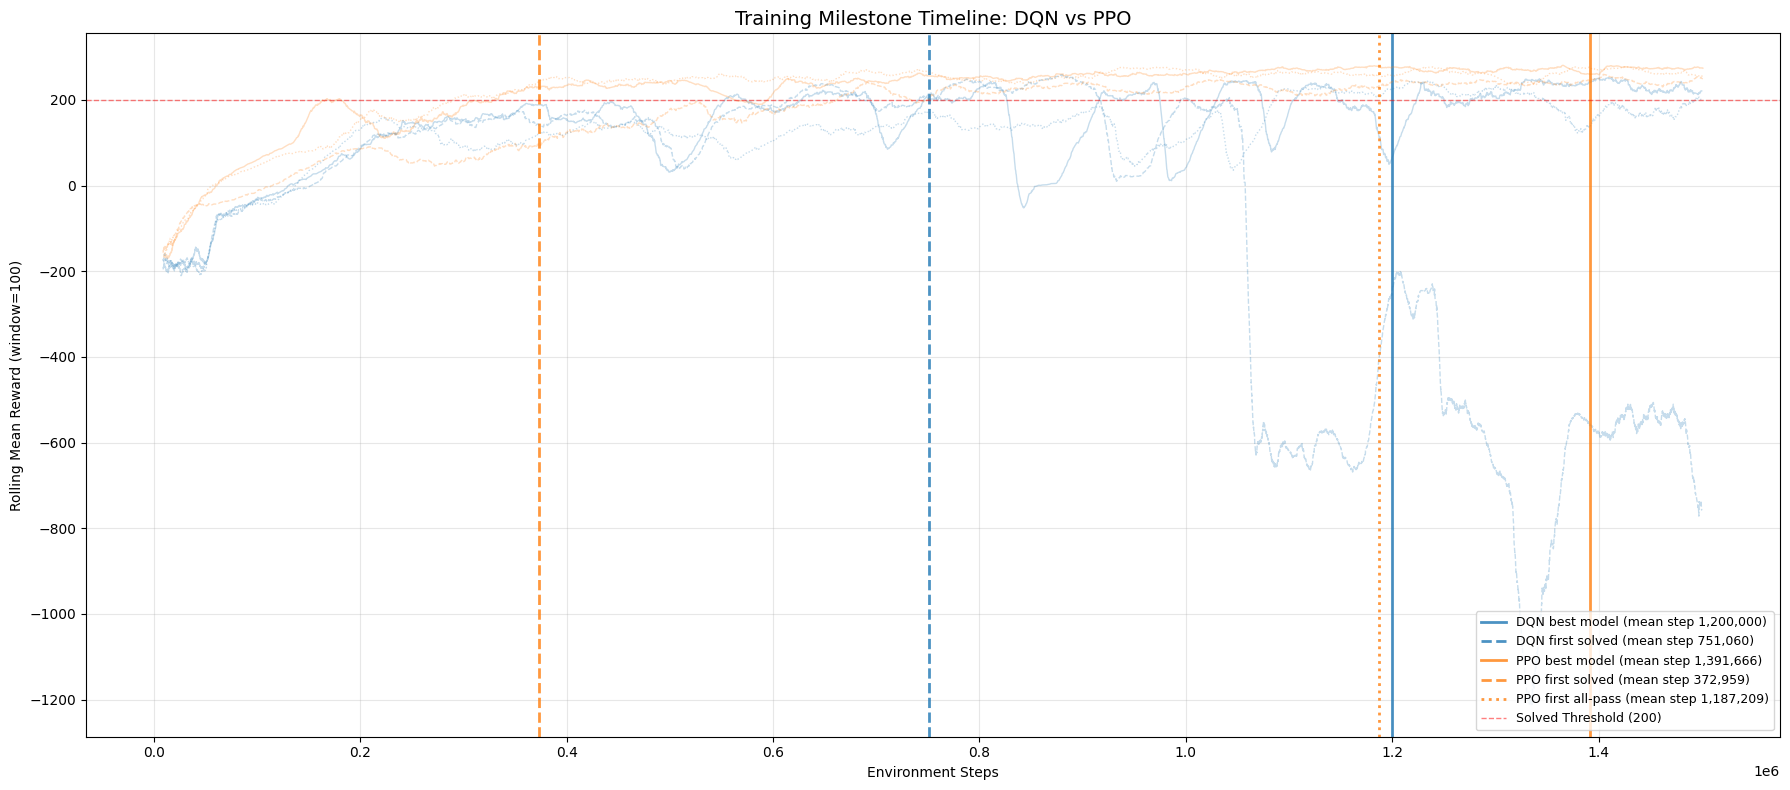

In [22]:
# Training Milestone Timeline
# Requires: training_log.npz (episode_rewards, episode_lengths) per run
#           evaluations.npz (timesteps, results) per run

def discover_training_logs(session_prefix):
    """
    Scan models/{algo}/{timestamp}/training_log.npz and return a dict:
        {algo: {seed: path_to_training_log}}
    """
    models_root = os.path.join(NOTEBOOK_DIR, "../../../models")
    logs = {}

    for algo_name in ALGORITHM_MAP:
        logs[algo_name] = {}
        algo_dir = os.path.join(models_root, algo_name)
        if not os.path.isdir(algo_dir):
            continue

        for run_folder in sorted(glob.glob(os.path.join(algo_dir, "????-??-??_??_??_??"))):
            log_path = os.path.join(run_folder, "training_log.npz")
            if not os.path.isfile(log_path):
                continue

            for f in os.listdir(run_folder):
                if f.startswith(session_prefix) and f.endswith(".zip") and f != "best_model.zip":
                    seed_str = f.replace(".zip", "").split("_")[-1]
                    if seed_str.isdigit():
                        seed_int = int(seed_str)
                        if seed_int in SEED_LIST:
                            logs[algo_name][seed_int] = log_path
                    break

    return logs


training_log_paths = discover_training_logs(SESSION_PREFIX)

print("Discovered training logs:")
for algo_name in ALGORITHM_MAP:
    for seed in SEED_LIST:
        path = training_log_paths.get(algo_name, {}).get(seed)
        status = path if path else "NOT FOUND"
        print(f"  {algo_name.upper()} seed {seed}: {status}")

# --- Compute milestones and build chart ---

ROLLING_WINDOW = 100
SOLVED_THRESHOLD = 200

fig, ax = plt.subplots(figsize=(18, 8))

# Lighter per-seed colors
seed_alpha = 0.25
seed_line_styles = ['-', '--', ':']

milestone_summary = []  # for the summary table

for algo_name in algo_names:
    color = algo_colors[algo_name]

    for si, seed in enumerate(SEED_LIST):
        log_path = training_log_paths.get(algo_name, {}).get(seed)
        if log_path is None:
            continue

        data = np.load(log_path)
        ep_rewards = data['episode_rewards']
        ep_lengths = data['episode_lengths']

        # Cumulative environment steps at end of each episode
        cum_steps = np.cumsum(ep_lengths)

        # Rolling mean reward (window=100)
        rolling_mean = pd.Series(ep_rewards).rolling(ROLLING_WINDOW).mean().values

        # Plot per-seed curve (light)
        ax.plot(cum_steps, rolling_mean, color=color, alpha=seed_alpha,
                linestyle=seed_line_styles[si], linewidth=1)

        # --- Milestone: first rolling mean >= 200 ---
        first_solved_step = None
        for j in range(ROLLING_WINDOW, len(ep_rewards)):
            if rolling_mean[j] >= SOLVED_THRESHOLD:
                first_solved_step = int(cum_steps[j])
                break

        # --- Milestone: first 100 consecutive all >= 200 ---
        first_allpass_step = None
        for j in range(ROLLING_WINDOW, len(ep_rewards)):
            window = ep_rewards[j - ROLLING_WINDOW + 1 : j + 1]
            if np.all(window >= SOLVED_THRESHOLD):
                first_allpass_step = int(cum_steps[j])
                break

        milestone_summary.append({
            'Algorithm': algo_name.upper(),
            'Seed': seed,
            'First Solved (rolling mean >= 200)': f'{first_solved_step:,}' if first_solved_step else 'Not reached',
            'First All-Pass (all 100 >= 200)': f'{first_allpass_step:,}' if first_allpass_step else 'Not reached',
        })

    # --- Best model milestone (from evaluations.npz, averaged across seeds) ---
    best_steps = []
    for seed in SEED_LIST:
        eval_path = eval_log_paths.get(algo_name, {}).get(seed)
        if eval_path is None:
            continue
        edata = np.load(eval_path, allow_pickle=True)
        timesteps = edata['timesteps']
        results = edata['results']
        best_score = -np.inf
        best_step = 0
        for k in range(len(timesteps)):
            score = np.mean(results[k]) - np.std(results[k])
            if score > best_score:
                best_score = score
                best_step = int(timesteps[k])
        best_steps.append(best_step)

    # --- Draw aggregate milestone lines ---
    # Collect per-seed first-solved steps for this algorithm
    algo_milestones = [m for m in milestone_summary if m['Algorithm'] == algo_name.upper()]

    solved_steps = []
    allpass_steps = []
    for m in algo_milestones:
        v = m['First Solved (rolling mean >= 200)']
        if v != 'Not reached':
            solved_steps.append(int(v.replace(',', '')))
        v = m['First All-Pass (all 100 >= 200)']
        if v != 'Not reached':
            allpass_steps.append(int(v.replace(',', '')))

    label_prefix = algo_name.upper()

    if best_steps:
        mean_best = int(np.mean(best_steps))
        ax.axvline(x=mean_best, color=color, linestyle='-', linewidth=2, alpha=0.8,
                   label=f'{label_prefix} best model (mean step {mean_best:,})')

    if solved_steps:
        mean_solved = int(np.mean(solved_steps))
        ax.axvline(x=mean_solved, color=color, linestyle='--', linewidth=2, alpha=0.8,
                   label=f'{label_prefix} first solved (mean step {mean_solved:,})')

    if allpass_steps:
        mean_allpass = int(np.mean(allpass_steps))
        ax.axvline(x=mean_allpass, color=color, linestyle=':', linewidth=2, alpha=0.8,
                   label=f'{label_prefix} first all-pass (mean step {mean_allpass:,})')

# Solved threshold line
ax.axhline(y=SOLVED_THRESHOLD, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Solved Threshold (200)')

ax.set_title('Training Milestone Timeline: DQN vs PPO', fontsize=14)
ax.set_xlabel('Environment Steps')
ax.set_ylabel('Rolling Mean Reward (window=100)')
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Figure 14** - Training milestone timeline showing rolling mean reward curves (per-seed, light lines) 
with vertical markers for best model selection, first solved (rolling 100-episode mean >= 200), 
and first all-pass (all 100 consecutive episodes >= 200) milestones.

Per-seed milestone details, showing the exact environment step at which each seed reached the solved 
and all-pass criteria.

In [32]:
# Milestone Summary Table

print('*** TRAINING MILESTONES PER SEED ***')
print(f'Rolling window: {ROLLING_WINDOW} episodes')
print(f'Solved threshold: mean reward >= {SOLVED_THRESHOLD}')
print(f'All-pass threshold: every episode in window >= {SOLVED_THRESHOLD}')
print()
print(pd.DataFrame(milestone_summary).to_string(index=False))

*** TRAINING MILESTONES PER SEED ***
Rolling window: 100 episodes
Solved threshold: mean reward >= 200
All-pass threshold: every episode in window >= 200

Algorithm  Seed First Solved (rolling mean >= 200) First All-Pass (all 100 >= 200)
      DQN    42                            553,533                     Not reached
      DQN   123                            614,569                     Not reached
      DQN  3407                          1,085,079                     Not reached
      PPO    42                            166,110                       1,407,532
      PPO   123                            662,791                     Not reached
      PPO  3407                            289,977                         966,886


---

## Final vs Best Model Comparison

In [24]:
# Evaluate final models (end-of-training) and compare against best models

final_evaluation_results = {}

for algo_name, algo_class in ALGORITHM_MAP.items():
    final_evaluation_results[algo_name] = {}

    for seed in SEED_LIST:
        load_path = final_model_paths.get(algo_name, {}).get(seed)
        if load_path is None:
            print(f"SKIPPING {algo_name.upper()} seed {seed} - final model not found")
            continue

        print(f"Evaluating {algo_name.upper()} seed {seed} (final model)...")

        def make_env(s=seed):
            env = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)
            env.reset(seed=s)
            return env

        model = algo_class.load(load_path, env=DummyVecEnv([make_env]), device=DEVICE)

        eval_env = Monitor(gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED))
        eval_env.reset(seed=seed)

        rewards, _ = evaluate_policy(
            model, eval_env,
            n_eval_episodes=EVALUATION_EPISODES,
            deterministic=True,
            return_episode_rewards=True
        )
        final_evaluation_results[algo_name][seed] = np.array(rewards)
        eval_env.close()

print("\nFinal model evaluation complete.")

Evaluating DQN seed 42 (final model)...
Evaluating DQN seed 123 (final model)...
Evaluating DQN seed 3407 (final model)...
Evaluating PPO seed 42 (final model)...
Evaluating PPO seed 123 (final model)...
Evaluating PPO seed 3407 (final model)...

Final model evaluation complete.


This table compares the best model (selected during training by the combined metric) against the final model (end-of-training snapshot). A positive delta means the best-model selection improved over simply using the last checkpoint, suggesting the agent's performance fluctuated or degraded late in training.

In [25]:
# Final vs Best Model Comparison Table

rows = []
for algo_name in algo_names:
    for seed in SEED_LIST:
        best_r = evaluation_results.get(algo_name, {}).get(seed)
        final_r = final_evaluation_results.get(algo_name, {}).get(seed)

        if best_r is None or final_r is None:
            continue

        rows.append({
            "Algorithm": algo_name.upper(),
            "Seed": seed,
            "Best Mean": f"{np.mean(best_r):.2f}",
            "Best Success": f"{(best_r >= 200).sum() / len(best_r) * 100:.0f}%",
            "Final Mean": f"{np.mean(final_r):.2f}",
            "Final Success": f"{(final_r >= 200).sum() / len(final_r) * 100:.0f}%",
            "Delta Mean": f"{np.mean(best_r) - np.mean(final_r):+.2f}",
        })

print("*** BEST MODEL vs FINAL MODEL ***")
print(f"Episodes per evaluation: {EVALUATION_EPISODES}")
print()
print(pd.DataFrame(rows).to_string(index=False))
print()
print("Positive Delta Mean = best model selection improved over end-of-training snapshot.")

*** BEST MODEL vs FINAL MODEL ***
Episodes per evaluation: 20

Algorithm  Seed Best Mean Best Success Final Mean Final Success Delta Mean
      DQN    42    278.51         100%     266.82           95%     +11.69
      DQN   123    283.34         100%    -935.49            0%   +1218.83
      DQN  3407    261.22         100%     286.92          100%     -25.70
      PPO    42    278.43         100%     276.39           95%      +2.04
      PPO   123    270.83         100%     247.72           85%     +23.11
      PPO  3407    279.56         100%     267.67           95%     +11.88

Positive Delta Mean = best model selection improved over end-of-training snapshot.


---

## Hyperparameter Exploration Summary

The final hyperparameter configuration used for each algorithm in this training session.

In [26]:
# Hyperparameter Tables: Final Configuration

for algo_name in ALGORITHM_MAP:
    params = ALGO_PARAMS[algo_name]
    rows = [{"Parameter": k, "Value": str(v)} for k, v in params.items()]
    rows.append({"Parameter": "total_timesteps", "Value": f"{TOTAL_TIMESTEPS:,}"})
    rows.append({"Parameter": "device", "Value": DEVICE})
    rows.append({"Parameter": "policy", "Value": "MlpPolicy"})

    print(f"*** {algo_name.upper()} Final Hyperparameters ***")
    print(pd.DataFrame(rows).to_string(index=False))
    print()

*** DQN Final Hyperparameters ***
             Parameter                   Value
         learning_rate linear_schedule(6.3e-4)
       learning_starts                   50000
           buffer_size                  750000
            batch_size                     128
                 gamma                    0.99
  exploration_fraction                    0.12
 exploration_final_eps                     0.1
target_update_interval                     250
            train_freq                       4
        gradient_steps                       4
         policy_kwargs     net_arch=[256, 256]
       total_timesteps               1,500,000
                device                     cpu
                policy               MlpPolicy

*** PPO Final Hyperparameters ***
      Parameter     Value
  learning_rate   0.00025
        n_steps      2048
     batch_size        64
       n_epochs        10
          gamma     0.999
     gae_lambda      0.95
       ent_coef      0.01
     clip_range   

Summary of all hyperparameter configurations tested across the project, showing how iterative tuning improved performance. This documents the experimental journey from baseline to final configuration.

In [27]:
# Hyperparameter Exploration Journey
# Summary of configurations tested across lab sessions and their results.
# Fill in the actual results from your earlier experiments (lab004, lab009, etc.)

print("*** DQN HYPERPARAMETER EXPLORATION ***")
print()

dqn_configs = [
    {
        "Config": "A (baseline)",
        "Key Changes": "lr=6.3e-4, buffer=100k, eps_final=0.01, explore=0.5, soft updates (tau=0.005)",
        "Success Rate": "84.0%",
        "Mean Reward": "245.47",
        "Notes": "Slow exploration decay, soft target updates",
    },
    {
        "Config": "B (Zoo-style)",
        "Key Changes": "lr=linear(6.3e-4), buffer=1M, eps_final=0.1, explore=0.12, hard updates (250)",
        "Success Rate": "96.0%",
        "Mean Reward": "263.02",
        "Notes": "Short exploration, high final epsilon, hard target updates",
    },
    {
        "Config": "C (final)",
        "Key Changes": "lr=linear(6.3e-4), buffer=750k, eps_final=0.1, explore=0.12, hard updates (250), learning_starts=50k",
        "Success Rate": "TBD (lab011)",
        "Mean Reward": "TBD (lab011)",
        "Notes": "Added learning_starts buffer fill, gradient_steps=4 explicit",
    },
]
print(pd.DataFrame(dqn_configs).to_string(index=False))

print()
print("*** PPO HYPERPARAMETER EXPLORATION ***")
print()

ppo_configs = [
    {
        "Config": "A (final)",
        "Key Changes": "lr=2.5e-4, gamma=0.999, n_steps=2048, batch=64, n_epochs=10, ent_coef=0.01",
        "Success Rate": "98.0%",
        "Mean Reward": "269.21",
        "Notes": "Standard config, single environment",
    },
]
print(pd.DataFrame(ppo_configs).to_string(index=False))
print()
print("Note: Update Config C results and add any additional configs tested during lab011 runs.")

*** DQN HYPERPARAMETER EXPLORATION ***

       Config                                                                                          Key Changes Success Rate  Mean Reward                                                        Notes
 A (baseline)                        lr=6.3e-4, buffer=100k, eps_final=0.01, explore=0.5, soft updates (tau=0.005)        84.0%       245.47                  Slow exploration decay, soft target updates
B (Zoo-style)                        lr=linear(6.3e-4), buffer=1M, eps_final=0.1, explore=0.12, hard updates (250)        96.0%       263.02   Short exploration, high final epsilon, hard target updates
    C (final) lr=linear(6.3e-4), buffer=750k, eps_final=0.1, explore=0.12, hard updates (250), learning_starts=50k TBD (lab011) TBD (lab011) Added learning_starts buffer fill, gradient_steps=4 explicit

*** PPO HYPERPARAMETER EXPLORATION ***

   Config                                                                Key Changes Success Rate Mean Reward  

---

## GIF Visualizations

Animated GIF visualizations of the best model for each algorithm and seed, showing a single deterministic evaluation episode. These provide qualitative insight into the landing behavior, including smoothness, engine usage, and approach strategy.

Generating GIF for DQN seed 42 (best model)...
  Saved: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/outputs_dqn/dqn_seed42.gif


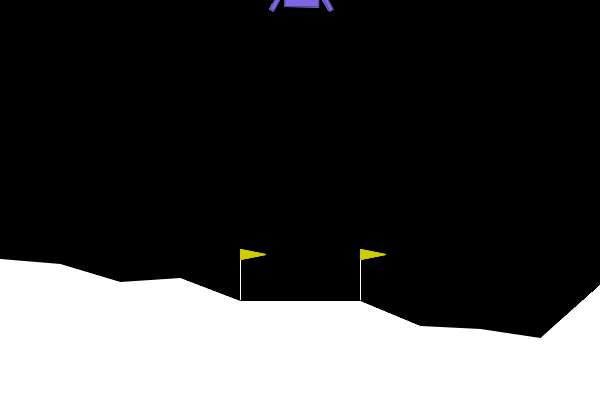

Generating GIF for DQN seed 123 (best model)...
  Saved: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/outputs_dqn/dqn_seed123.gif


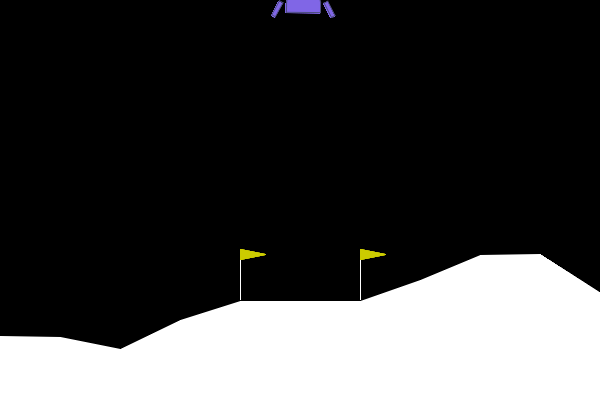

Generating GIF for DQN seed 3407 (best model)...
  Saved: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/outputs_dqn/dqn_seed3407.gif


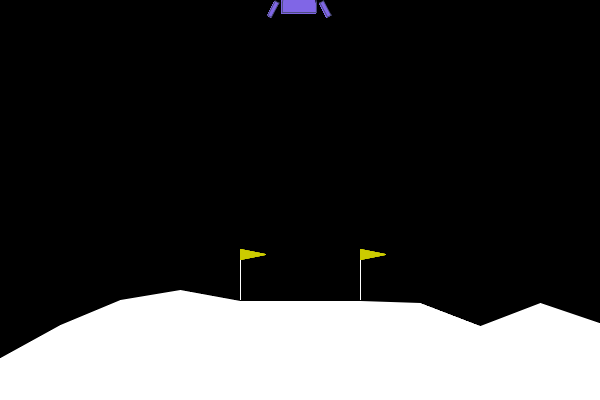

Generating GIF for PPO seed 42 (best model)...
  Saved: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/outputs_ppo/ppo_seed42.gif


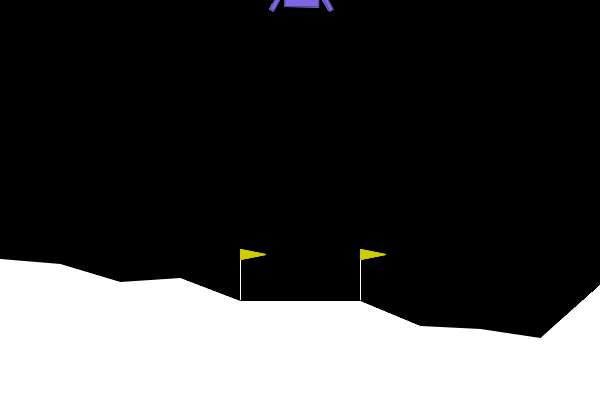

Generating GIF for PPO seed 123 (best model)...
  Saved: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/outputs_ppo/ppo_seed123.gif


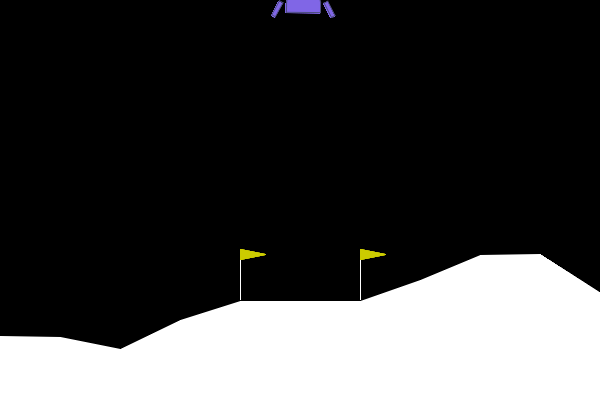

Generating GIF for PPO seed 3407 (best model)...
  Saved: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/outputs_ppo/ppo_seed3407.gif


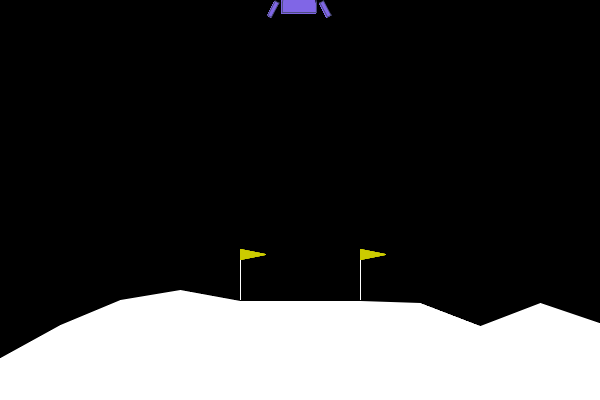

In [28]:
# GIF Visualizations (one per algorithm per seed, best model)

for algo_name, algo_class in ALGORITHM_MAP.items():
    output_dir = os.path.join(NOTEBOOK_DIR, "outputs_" + algo_name)
    os.makedirs(output_dir, exist_ok=True)

    for seed in SEED_LIST:
        load_path = best_model_paths.get(algo_name, {}).get(seed)
        if load_path is None:
            print(f"SKIPPING GIF for {algo_name.upper()} seed {seed} - best model not found")
            continue

        print(f"Generating GIF for {algo_name.upper()} seed {seed} (best model)...")

        def make_vis_env(s=seed):
            env = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)
            env.reset(seed=s)
            return env

        vis_model = algo_class.load(load_path, env=DummyVecEnv([make_vis_env]), device=DEVICE)

        vis_env = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)
        frames = []
        obs, info = vis_env.reset(seed=seed)
        done = False

        while not done:
            action, _ = vis_model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = vis_env.step(action)
            done = terminated or truncated
            frames.append(vis_env.render())

        vis_env.close()

        gif_path = os.path.join(output_dir, f"{algo_name}_seed{seed}.gif")
        imageio.mimsave(gif_path, frames, fps=30)
        print(f"  Saved: {gif_path}")
        display(Image(filename=gif_path))

**Figure 13** - Animated visualization of a single deterministic evaluation episode for each algorithm and seed.

---

## Appendix: Experimental Setup

Programmatic inspection of the environment to confirm the observation and action space dimensions match the documented values.

In [29]:
# Environment inspection

env_tmp = gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED)
print(f"Environment: {GYMNASIUM_MODEL}")
print(f"Observation space: {env_tmp.observation_space}")
print(f"Action space: {env_tmp.action_space}")
print(f"Wind enabled: {WIND_ENABLED}")

obs, info = env_tmp.reset(seed=42)
print(f"\nSample observation: {obs}")
print(f"Observation labels: [x, y, vx, vy, angle, angular_vel, left_leg, right_leg]")
env_tmp.close()

Environment: LunarLander-v3
Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)
Wind enabled: False

Sample observation: [ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]
Observation labels: [x, y, vx, vy, angle, angular_vel, left_leg, right_leg]


Library versions used for this evaluation run, ensuring reproducibility.

In [30]:
# System and library versions

import stable_baselines3

print(f"Python: {sys.version.split()[0]}")
print(f"PyTorch: {torch.__version__}")
print(f"Stable-Baselines3: {stable_baselines3.__version__}")
print(f"Gymnasium: {gym.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Device: {DEVICE}")
print(f"CUDA: {torch.version.cuda if torch.cuda.is_available() else 'Not available'}")

Python: 3.12.3
PyTorch: 2.10.0+cu130
Stable-Baselines3: 2.7.1
Gymnasium: 1.2.3
NumPy: 2.4.2
Device: cpu
CUDA: 13.0


## 7. Conceptual Discussion

This section presents a theoretical discussion of the core conceptual differences between value-based and policy-based reinforcement learning methods, the sources of instability in deep RL, and the exploration mechanisms used in DQN and PPO.

---

### 7.1 Value-Based vs Policy-Based Learning

Reinforcement Learning algorithms can be categorised according to what is parameterised and optimised.

#### Value-Based Learning

Value-based methods approximate a value function, typically the action-value function:

$$
Q^\pi(s,a) = \mathbb{E}_\pi \left[ \sum_{t=0}^{\infty} \gamma^t r_t \mid s_0 = s, a_0 = a \right]
$$

The optimal policy is derived implicitly:

$$
\pi(s) = \arg\max_a Q(s,a)
$$

Deep Q-Networks (DQN) approximate $Q(s,a; \theta)$ and update parameters using the Bellman optimality equation:

$$
Q(s,a) = r + \gamma \max_{a'} Q(s',a')
$$

This introduces **bootstrapping**, since the target depends on the model's own predictions.

Key characteristics:

- Off-policy learning
- Bootstrapping
- Policy extracted via maximisation

However, the use of the max operator combined with function approximation introduces instability.

#### Policy-Based Learning

Policy-based methods parameterise the policy directly:

$$
\pi_\theta(a|s)
$$

and optimise the expected return:

$$
J(\theta) = \mathbb{E}_{\pi_\theta}[R]
$$

Using the policy gradient theorem:

$$
\nabla_\theta J(\theta) =
\mathbb{E}_{\pi_\theta}
\left[
\nabla_\theta \log \pi_\theta(a|s) A^\pi(s,a)
\right]
$$

These methods:

- Learn the policy directly
- Avoid explicit maximisation over value estimates
- Naturally handle continuous action spaces

Because they do not rely on a max operator over Q-values, they tend to be structurally more stable in deep settings.

---

### 7.2 Overestimation and Instability in Value-Based Algorithms

#### Overestimation Bias

Overestimation arises from the maximisation step $\max_a Q(s,a)$. If Q-value estimates contain zero-mean noise:

$$
\mathbb{E}[\max(X_i)] \ge \max(\mathbb{E}[X_i])
$$

Thus, even unbiased estimators lead to positively biased maximum estimates.

In DQN, the same network selects the action (argmax) and evaluates the action. This coupling amplifies overestimation bias.

#### Structural Instability: The Deadly Triad

Deep value-based RL combines:

1. Function approximation
2. Bootstrapping
3. Off-policy learning

This combination is known as the **deadly triad**, which may cause divergence or unstable oscillations.

PPO avoids these structural issues because:

- It does not use a max over Q-values
- It performs on-policy updates
- Value estimates are auxiliary rather than directly driving action selection

---

### 7.3 PPO Clipping and Generalised Advantage Estimation (GAE)

#### PPO Clipped Objective

PPO constrains policy updates through the clipped surrogate objective:

$$
L^{CLIP}(\theta) =
\mathbb{E}
\left[
\min
\left(
r_t(\theta) A_t,
\text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) A_t
\right)
\right]
$$

where:

$$
r_t(\theta) =
\frac{\pi_\theta(a_t|s_t)}
{\pi_{\theta_{old}}(a_t|s_t)}
$$

This objective:

- Approximates a trust-region method
- Prevents excessively large updates
- Improves training stability

#### Generalised Advantage Estimation (GAE)

The advantage function is defined as:

$$
A^\pi(s,a) = Q^\pi(s,a) - V^\pi(s)
$$

GAE computes:

$$
A_t^{GAE(\lambda)} =
\sum_{l=0}^{\infty}
(\gamma \lambda)^l \delta_{t+l}
$$

where the temporal-difference residual is:

$$
\delta_t =
r_t + \gamma V(s_{t+1}) - V(s_t)
$$

The parameter $\lambda \in [0,1]$ controls the bias-variance trade-off:

- $\lambda = 0$: lower variance, higher bias
- $\lambda = 1$: lower bias, higher variance

GAE reduces variance in policy gradient updates while maintaining acceptable bias, improving sample efficiency and stability.

---

### 7.4 Epsilon-Greedy vs Entropy-Driven Exploration

#### Epsilon-Greedy Exploration (DQN)

The behaviour policy is defined as:

$$
\pi(a|s) =
\begin{cases}
\text{random action} & \text{with probability } \epsilon \\
\arg\max_a Q(s,a) & \text{otherwise}
\end{cases}
$$

Limitations:

- Uniform and uninformed exploration
- Independent of uncertainty
- Becomes fully greedy as $\epsilon \to 0$

Exploration is externally imposed rather than integrated into optimisation.

#### Entropy-Regularised Exploration (PPO)

PPO includes an entropy bonus in the objective:

$$
L =
L^{CLIP}
+
\beta
\mathbb{E}[H(\pi_\theta(\cdot|s))]
$$

where entropy is defined as:

$$
H(\pi) =
-
\sum_a
\pi(a|s)
\log \pi(a|s)
$$

This mechanism:

- Encourages stochastic policies early in training
- Gradually reduces randomness
- Couples exploration with optimisation

Unlike epsilon-greedy, exploration is intrinsic to the learning objective.

---

### Conceptual Summary

In summary, value-based methods optimise an approximation of the value function and derive the policy implicitly through action maximisation. This structural reliance on the max operator and bootstrapping introduces overestimation bias and makes deep value-based methods particularly sensitive to instability when combined with function approximation and off-policy learning. In contrast, policy-based methods directly parameterise and optimise the policy, avoiding explicit maximisation over value estimates and thereby reducing structural sources of instability. PPO further improves stability through its clipped surrogate objective, which constrains policy updates, and through Generalised Advantage Estimation, which manages the bias-variance trade-off in gradient estimates. Regarding exploration, epsilon-greedy strategies impose external and uninformed randomness that vanishes as epsilon decays, whereas entropy-regularised exploration integrates stochasticity directly into the optimisation objective, allowing exploration to adapt naturally as learning progresses. Overall, these theoretical differences explain why PPO typically exhibits smoother and more stable learning dynamics compared to DQN in complex environments.

---